# Causal Forest Preperation and Implementation using econml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import requests
import time
import re
import censusdata
from tqdm import tqdm
from tqdm.notebook import trange

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.base import clone
from econml.dml import CausalForestDML
from shapely.geometry import Point

from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats 

os.chdir('/Users/theomoers/Documents/Columbia SIPA/Classes/Spring/Applying ML/ml-final-project/')
randomState = 18

# plt.switch_backend('pgf') # change to 'pgf' for LaTeX export # use inline for Jupyter Notebook
%matplotlib inline 

plt.rcParams.update({ # for Latex export
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

In [4]:
manuf_meta = pd.read_csv('data/manufacturing_energy_and_industry_facility_metadata.csv', header=3)
socioecon = pd.read_csv('data/socioeconomics.csv', header=3)

In [5]:
subset = manuf_meta[[
    'Segment', 
    'Technology', 
    'Subcategory', 
    'Decarb_Sector', 
    'Project_Type', 
    'Estimated_Total_Facility_CAPEX', 
    'CD119_2024_Name', 
    'Announcement_Date',
    'State',
    'US Senator 1: Party',
    'US Senator 2: Party',
    'US Representative Party',
    'Latitude',
    'Longitude',
    ]]

# get year range from announcement date
subset['Announcement_Date'] = pd.to_datetime(subset['Announcement_Date'], errors='coerce')
subset['Announcement_Year'] = subset['Announcement_Date'].dt.year # for overall year 
subset['Announcement_Quarter'] = subset['Announcement_Date'].dt.quarter # for seasonality
years = subset['Announcement_Year'].unique()
years.sort() # for socioeconomic data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Getting additional weather data

In [6]:
START = "20200101" 
END   = "20201231"

PARAMS = ["ALLSKY_SFC_SW_DWN", # All Sky Surface Shortwave Downward Irradiance
            "WS2M", # Wind Speed at 2 Meters
            "WS2M_MAX", # Maximum Wind Speed at 2 Meters
            "WS50M", # Wind Speed at 50 Meters
            "T2M", # Air Temperature at 2 Meters
            "T2M_MAX", # Maximum Air Temperature at 2 Meters
            "T2M_MIN", # Minimum Air Temperature at 2 Meters
            "PRECTOTCORR"] # Total Precipitation

PAUSE_SEC = 1.0

def fetch_nasa_power(lat, lon, start=START, end=END, parameters=PARAMS):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params_str = ",".join(parameters)
    url = (
        f"{base_url}"
        f"?start={start}&end={end}"
        f"&latitude={lat}&longitude={lon}"
        f"&parameters={params_str}"
        f"&community=RE&format=JSON"
    )
    try:
        resp = requests.get(url, timeout=30)
        resp.raise_for_status()
    except requests.HTTPError as e:
        try:
            print(f"API error for ({lat}, {lon}):",
                  resp.status_code, resp.json())
        except Exception:
            print(f"API error for ({lat}, {lon}):", resp.status_code, resp.text)
        raise     
    data = resp.json()["properties"]["parameter"]
    dates = list(data[parameters[0]].keys())
    df = pd.DataFrame(
        {p: list(data[p].values()) for p in parameters},
        index=pd.to_datetime(dates, format="%Y%m%d"),
    )
    return df

def process_location(lat, lon):
    try:
        df_daily = fetch_nasa_power(lat, lon)
        annual_means = df_daily.mean().to_dict()
    except Exception:
        annual_means = {p: pd.NA for p in PARAMS}
    time.sleep(PAUSE_SEC)
    return {"Latitude": lat, "Longitude": lon, **annual_means}

In [ ]:
# this takes very long, can just import resulting csv below
"""
coords = list(zip(subset["Latitude"], subset["Longitude"]))

results = []
with ThreadPoolExecutor(max_workers=5) as executor: # Max threas given by the NASA Power is 5
    futures = [executor.submit(process_location, lat, lon) 
               for lat, lon in coords]
    for f in tqdm(as_completed(futures),
                  total=len(futures),
                  desc="Fetching data"):
        results.append(f.result())

df_results = pd.DataFrame(results)
subset_with_weather = subset.merge(df_results, on=["Latitude", "Longitude"], how="left")
subset_with_weather.head()
subset = subset_with_weather

subset_with_weather.to_csv("/data/posteda/subset_with_weather.csv", index=False)"""

Fetching data:  26%|██▌       | 2216/8532 [33:50<1:18:27,  1.34it/s]

API error for (333.56812, -112.704): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct latitude value.']}


Fetching data:  84%|████████▍ | 7165/8532 [1:49:37<22:50,  1.00s/it]  

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Fetching data:  92%|█████████▏| 7807/8532 [1:59:17<09:41,  1.25it/s]

API error for (333.56812, -112.704): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct latitude value.']}


Fetching data: 100%|██████████| 8532/8532 [2:10:11<00:00,  1.09it/s]


In [7]:
subset = pd.read_csv('data/posteda/subset_with_weather.csv')

In [8]:
# manualf fix for the row with lat=333.56812 and lon=-112.704 to correct values
subset.loc[(subset['Latitude'] > 333.0) & (subset['Latitude'] < 334.0) & (subset['Longitude'] < -112.0) & (subset['Longitude'] > -113.0), 'Latitude'] = 37.090240
subset.loc[(subset['Latitude'] > 333.0) & (subset['Latitude'] < 334.0) & (subset['Longitude'] < -112.0) & (subset['Longitude'] > -113.0), 'Latitude'] = -95.712891
subset = subset.drop_duplicates()

In [9]:
subset[PARAMS] = subset[PARAMS].apply(pd.to_numeric, errors='coerce')

max_iter = 2
iteration = 0

while iteration < max_iter:
    nan_rows = subset[subset[PARAMS].isna().all(axis=1)]
    if nan_rows.empty:
        print(f"All nans fixed after {iteration} iteration(s).")
        break
    print(f"Iteration {iteration + 1}: attempting to fix {len(nan_rows)} remaining row(s)…")

    coords = list(zip(nan_rows["Latitude"], nan_rows["Longitude"]))
    results = []

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(process_location, lat, lon) for lat, lon in coords]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Completing missing rows"):
            results.append(f.result())

    df_results = pd.DataFrame(results)

    extra_rows = nan_rows.merge(df_results, on=["Latitude", "Longitude"], how="left", suffixes=("", "_new"))

    for _, row in tqdm(extra_rows.iterrows(), total=extra_rows.shape[0], desc="Plugging values into original subset"):
        mask = (subset['Latitude'] == row['Latitude']) & (subset['Longitude'] == row['Longitude'])
        for p in PARAMS:
            subset.loc[mask, p] = row[f"{p}_new"]

    iteration += 1
else:
    remaining = subset[subset[PARAMS].isna().all(axis=1)]
    print(f"Reached max_iter={max_iter} with {len(remaining)} row(s) still missing data.")
    print("Overwriting previous csv")

# rename weather columns
subset.rename(columns={
    "ALLSKY_SFC_SW_DWN": "solar_irradiance",
    "WS2M": "wind_speed_2m",
    "WS2M_MAX": "wind_speed_2m_max",
    "WS50M": "wind_speed_50m",
    "T2M": "air_temp_2m",
    "T2M_MAX": "air_temp_2m_max",
    "T2M_MIN": "air_temp_2m_min",
    "PRECTOTCORR": "precipitation",
}, inplace=True)

# make a list using nice names
SELECT = ['solar_irradiance', 
          'wind_speed_2m', 
          'wind_speed_2m_max', 
          'wind_speed_50m', 
          'air_temp_2m', 
          'air_temp_2m_max', 
          'air_temp_2m_min', 
          'precipitation']

subset.to_csv("data/posteda/subset_with_weatherV2.csv", index=False)

# subset = pd.read_csv('/Users/theomoers/Documents/Columbia SIPA/Classes/Spring/Applying ML/ml-final-project/data/posteda/subset_with_weather.csv', header=0)

Iteration 1: attempting to fix 3 remaining row(s)…


Completing missing rows:   0%|          | 0/3 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 5/5 [00:00<00:00, 628.76it/s]


Iteration 2: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 502 {'message': 'Internal server error'}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 467.07it/s]


Iteration 3: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 312.70it/s]


Iteration 4: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 175.16it/s]


Iteration 5: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 564.36it/s]


Reached max_iter=5 with 1 row(s) still missing data.
Overwriting previous csv


In [10]:
mask = subset[SELECT].isna().any(axis=1)
subset = subset[~mask]
subset.reset_index(drop=True, inplace=True)

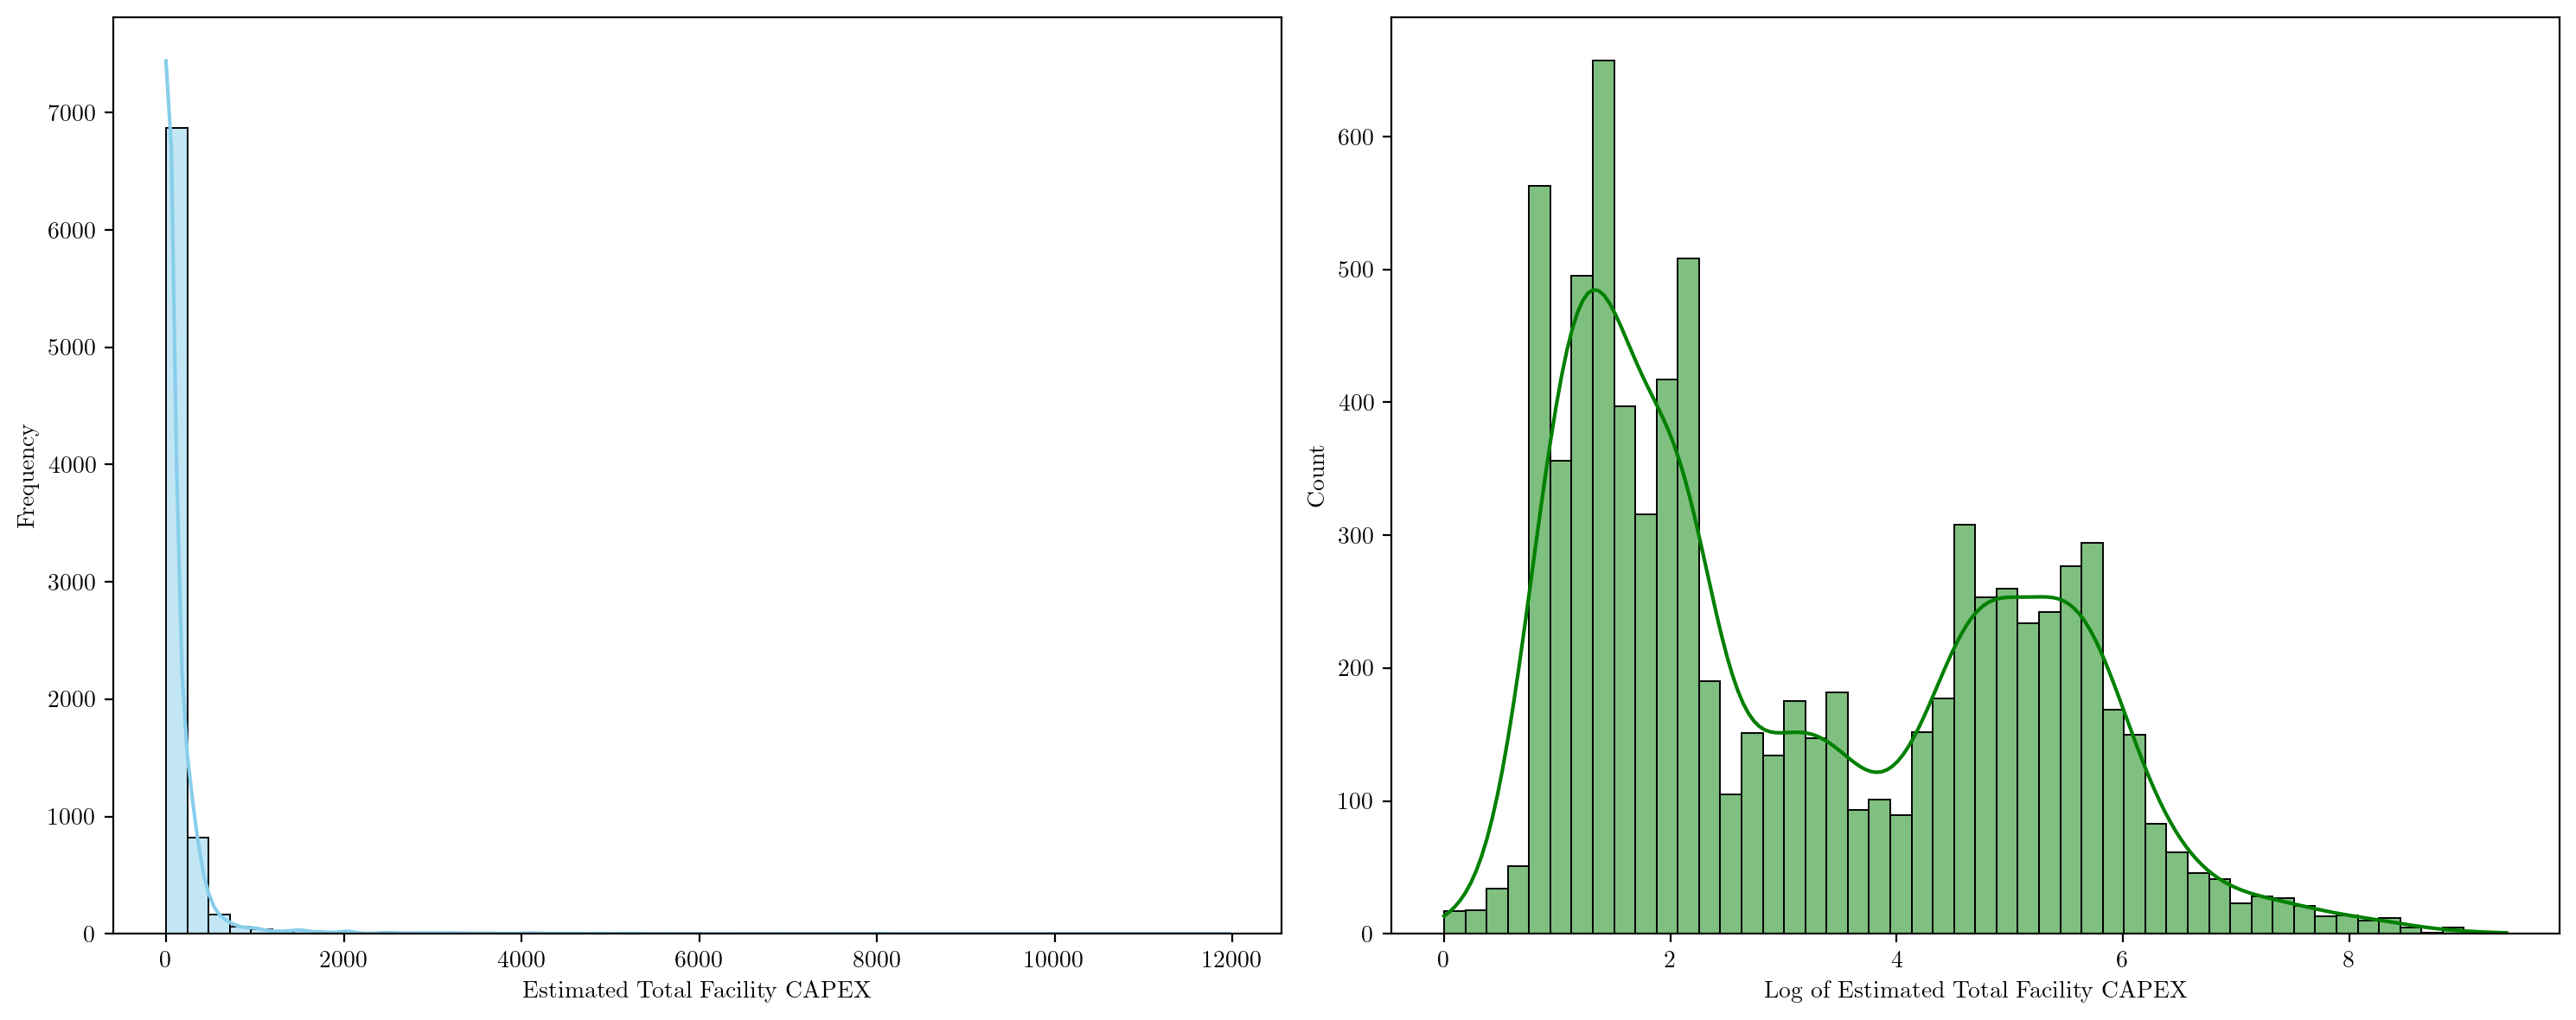

In [ ]:
# histogram of CAPEX, Fig A.1
fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=200)
sns.histplot(subset['Estimated_Total_Facility_CAPEX'], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].set_xlabel('Estimated Total Facility CAPEX')
ax[0].set_ylabel('Frequency')
loging = np.log(subset['Estimated_Total_Facility_CAPEX'] + 1)
sns.histplot(loging, bins=50, kde=True, ax=ax[1], color='green')
ax[1].set_xlabel('Log of Estimated Total Facility CAPEX')
plt.tight_layout()
plt.savefig('figures/Methods/histogram_CAPEX.png', dpi=200)
plt.show()

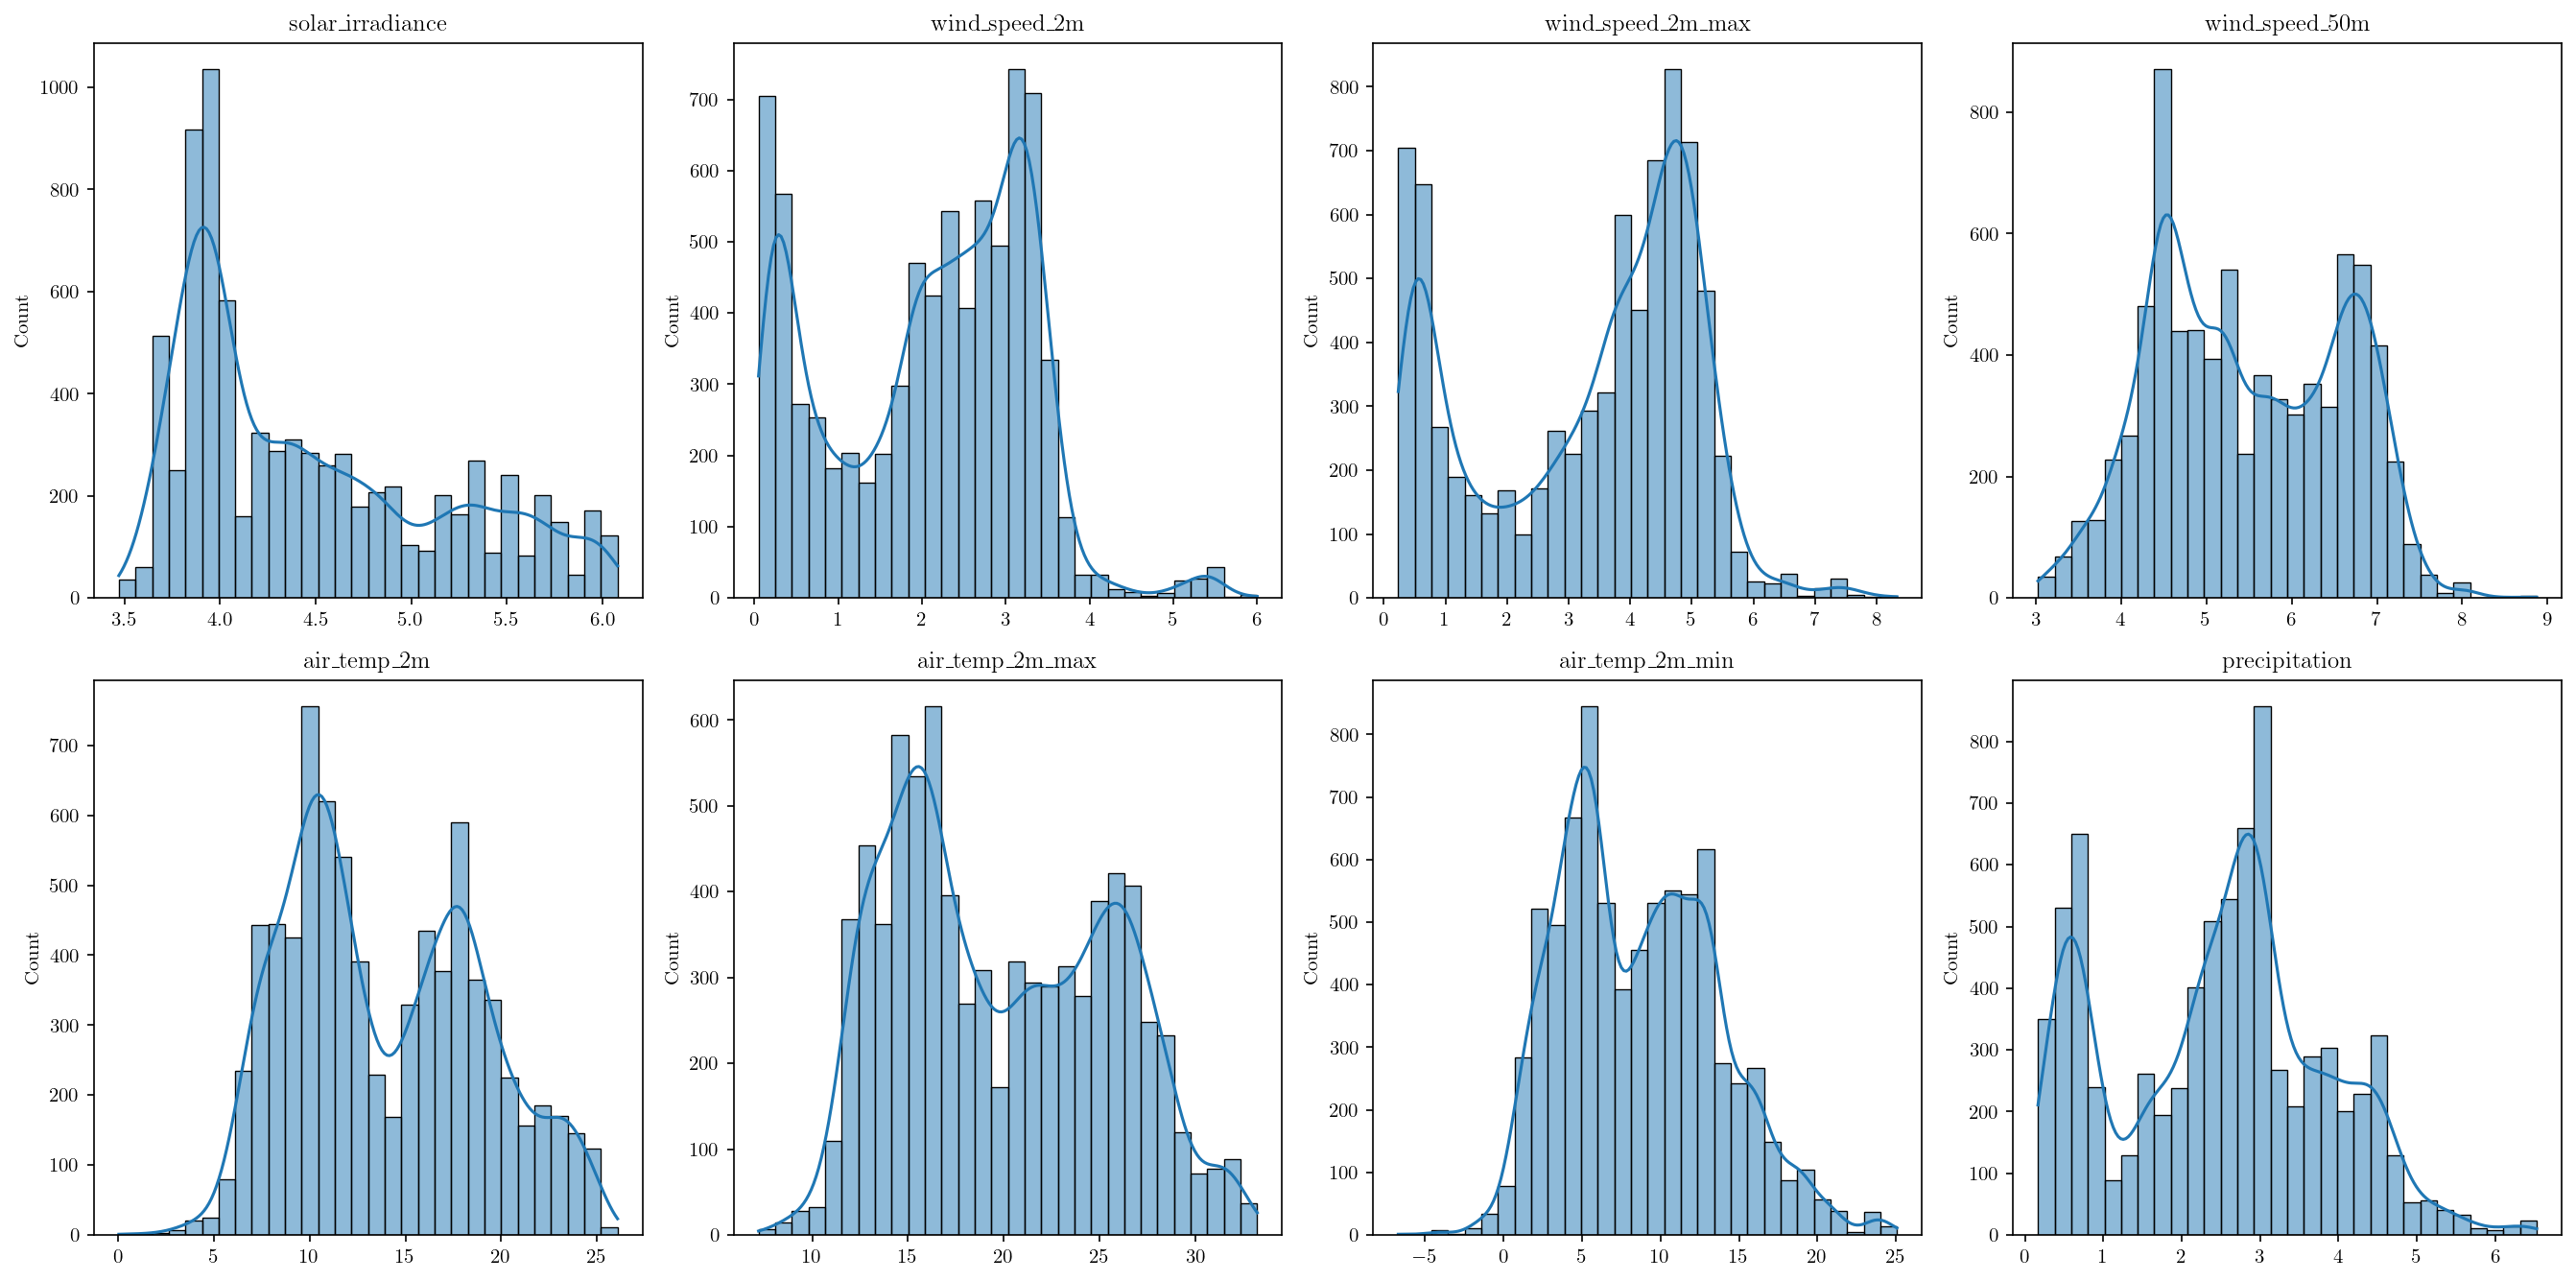

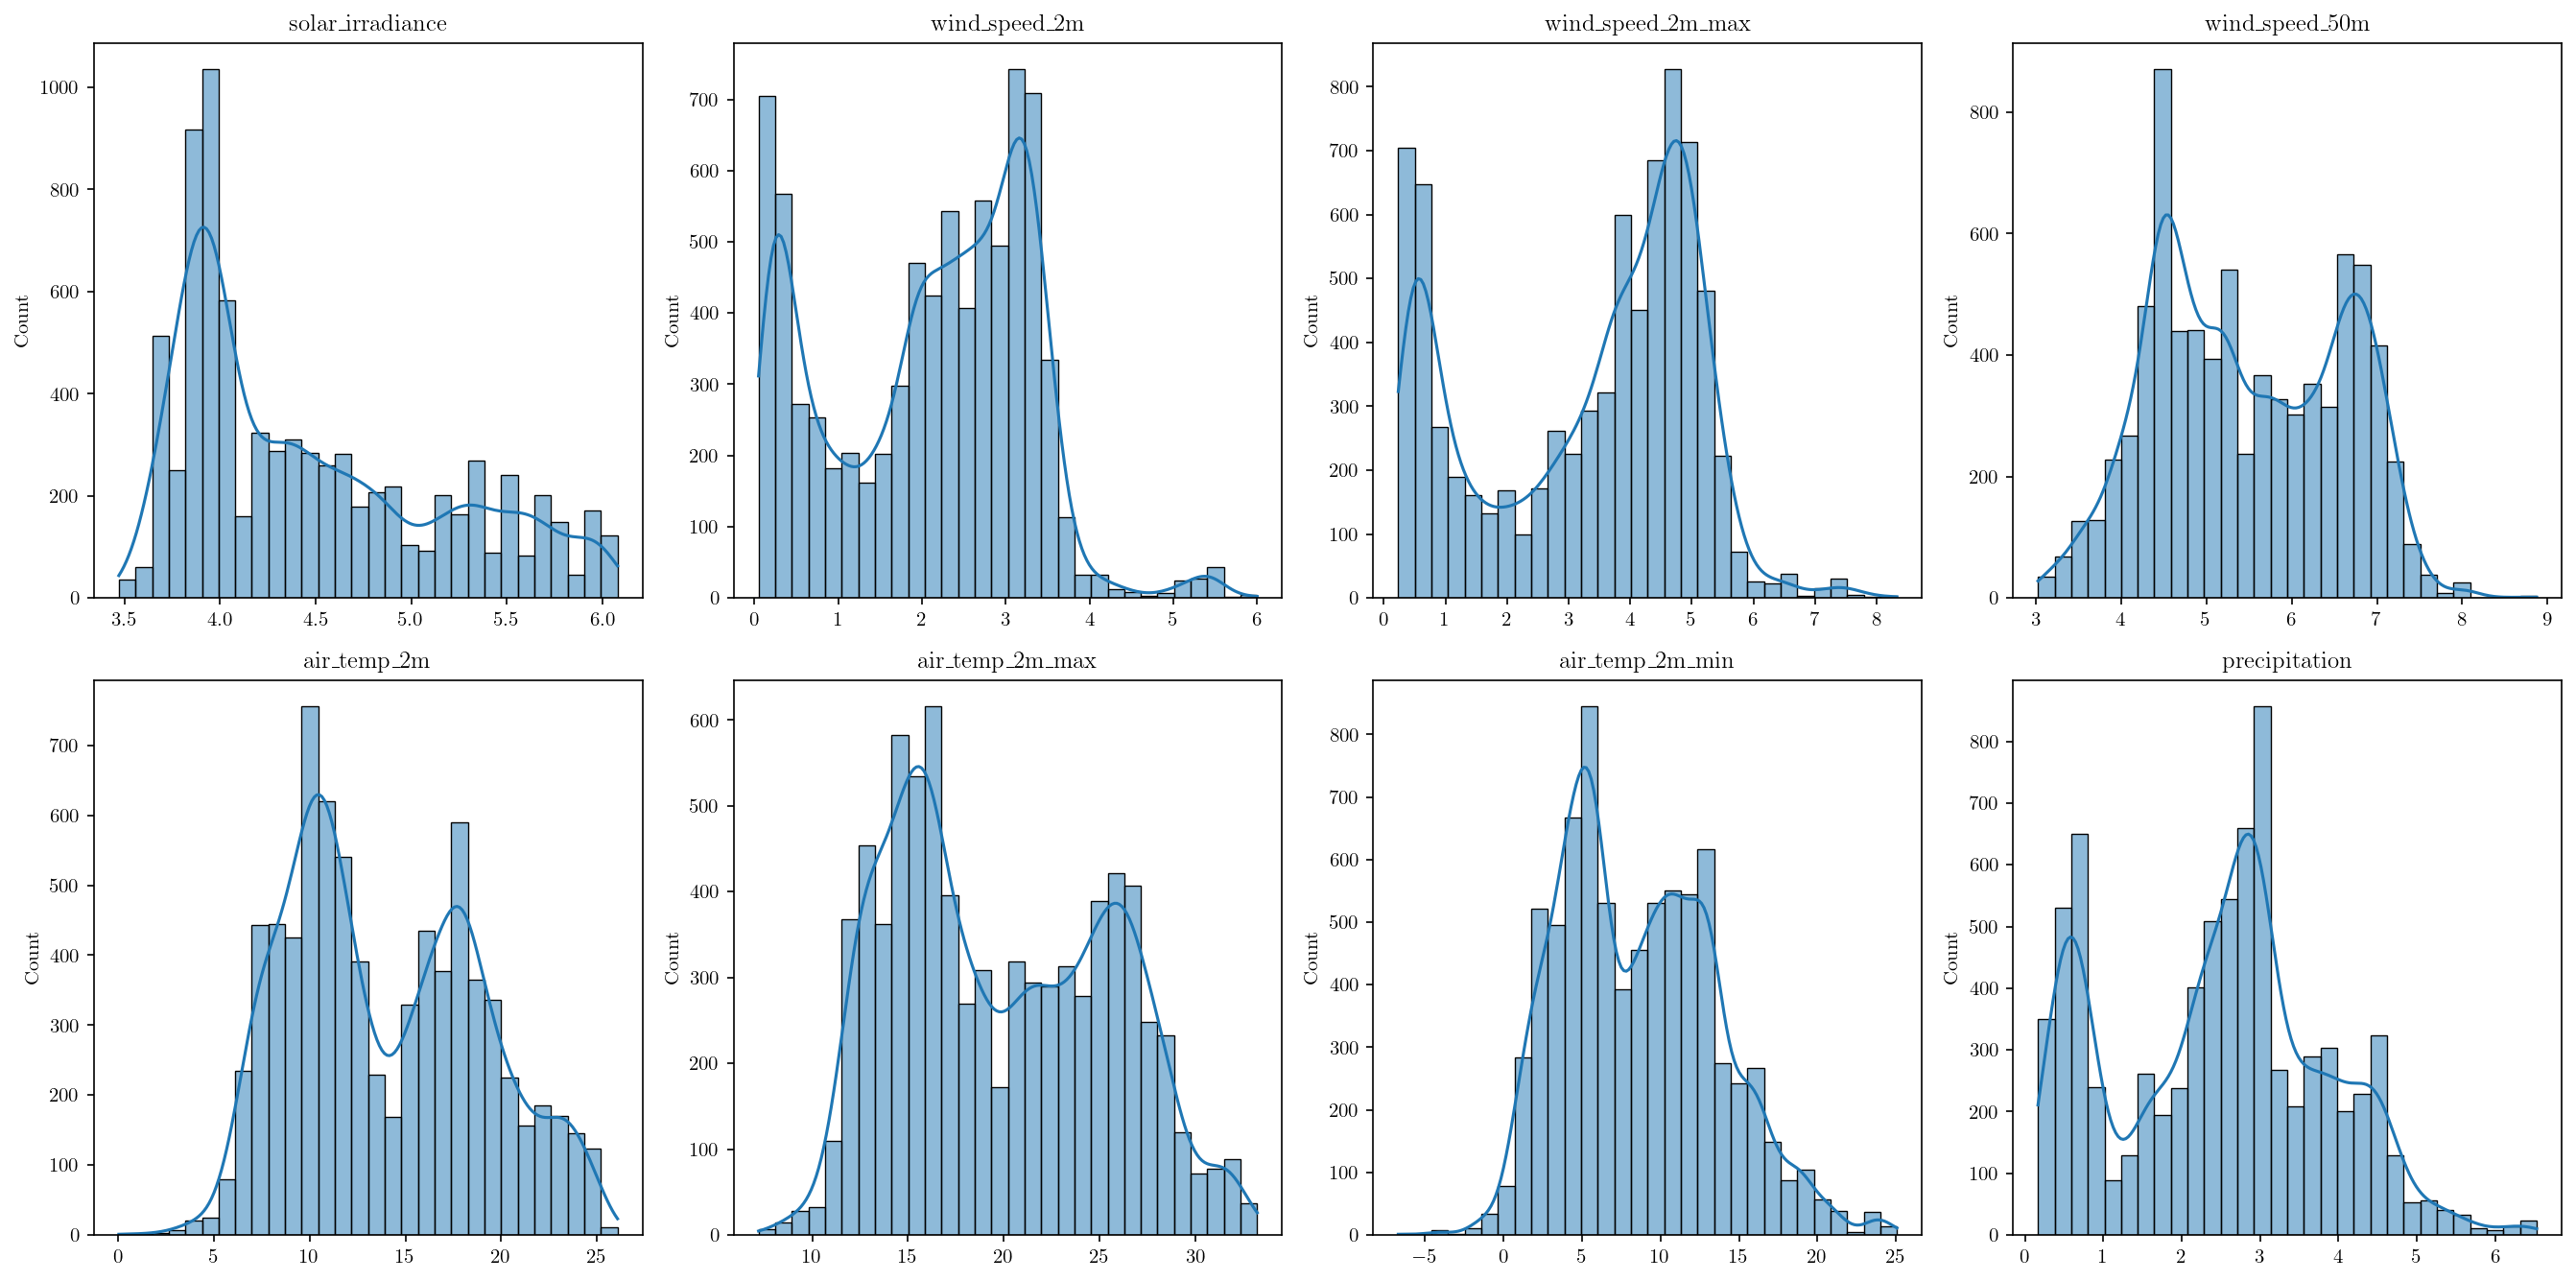

In [ ]:
# plot select weather variables as histograms (6 in total), Fig. A.2
def plot_histograms(df, columns, ncols=3):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 9), dpi=150)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('figures/Methods/weather_data_distribution.png', bbox_inches='tight')
    plt.show()
plot_histograms(subset, SELECT, ncols=4)



#### Getting additional socioeconomic data

In [31]:
years = subset['Announcement_Year'].unique()
years.sort() # for socioeconomic data

In [32]:
vars_acs = {
    'B19013_001E': 'med_household_income',
    'B23025_005E': 'unemployed',
    'B01003_001E': 'total_pop',
    'B19083_001E': 'gini',
    
}
years = years[:-1] # 2024 not yet available, will be extrapolated, see below
def download_year(year):
    df = censusdata.download(
        src='acs5',
        year=year,
        geo=censusdata.censusgeo([('congressional district', '*')]),
        var=list(vars_acs.keys())
    )
    df = (
        df
        .rename(columns=vars_acs)
        .reset_index()
        .rename(columns={'index': 'geography'})
    )
    df['year'] = year
    return df

# cap threads at either # of CPU cores or # of years
max_workers = min(len(years), os.cpu_count() or 1)

# run downloads in parallel threads with tqdm.notebook
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # executor.map returns results in the same order as 'years'
    results = list(
        tqdm(
            executor.map(download_year, years),
            total=len(years),
            desc='Downloading ACS by year'
        )
    )

# concatenate everything into one DataFrame
df_acs = pd.concat(results, ignore_index=True)
# save to csv
df_acs.to_csv('data/posteda/acs_data.csv', index=False)

In [33]:
df_acs['geography_str'] = df_acs['geography'].astype(str)
df_acs = df_acs[df_acs['geography_str'].str.contains('Congressional District')]
df_acs = df_acs[~df_acs['geography_str'].str.contains('not defined')]
df_acs = df_acs[~df_acs['geography_str'].str.contains('at large')]
df_acs = df_acs[~df_acs['geography_str'].str.contains('at Large')]
df_acs.to_csv('data/posteda/acs_data.csv', index=False)

In [34]:
df_acs['geography'] = df_acs['geography'].astype(str)

state2abbr = dict(pd.read_csv(
    "https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv"
).values)

def extract_cd(geo_str: str) -> str:
    # 1) grab the state name after “),” and before “: Summary”
    m_state = re.search(r'\),\s*([^:]+):', geo_str)
    state_name = m_state.group(1).strip() if m_state else None
    abbr = state2abbr.get(state_name, '??')

    # 2) grab the two-digit district code
    m_cd = re.search(r'congressional district[:\s]*(\d+)', geo_str, re.IGNORECASE)
    cd = m_cd.group(1).zfill(2) if m_cd else '00'

    return f"{abbr}-{cd}"

# apply to your dataframe:
df_acs['state_cd'] = df_acs['geography'].apply(extract_cd)

In [35]:
def forecast_by_state(df,
                      vars_to_forecast=None,
                      group_col='state_cd',
                      start_year=2020,
                      end_year=2023,
                      forecast_year=2024):
    if vars_to_forecast is None:
        vars_to_forecast = ['med_household_income', 'unemployed', 'total_pop', 'gini']

    predictions = []
    df = df.copy()
    df['year'] = df['year'].astype(int)

    for state, grp in df.groupby(group_col):
        sub = grp[(grp['year'] >= start_year) & (grp['year'] <= end_year)]
        if len(sub) < 2:
            print(f"Skipping {state!r}: only {len(sub)} years of data")
            continue

        years = sub['year'].values
        pred_row = {group_col: state, 'year': forecast_year}
        for var in vars_to_forecast:
            y = sub[var].values
            m, b = np.polyfit(years, y, 1) # fit simple linear trend
            pred_row[var] = m * forecast_year + b
        predictions.append(pred_row)

    pred_df = pd.DataFrame(predictions)
    df_extended = pd.concat([df, pred_df], ignore_index=True)
    return df_extended

df_extended = forecast_by_state(df_acs)
df_extended.to_csv('data/posteda/acs_with_2024.csv', index=False)
df_acs = df_extended

In [36]:
df_acs = pd.read_csv('data/posteda/acs_with_2024.csv', header=0)
# make mask with no nan values for CD119_2024_Name
mask = subset['CD119_2024_Name'].isna()
subset = subset[~mask]
subset.reset_index(drop=True, inplace=True)

In [37]:
# for each row in subset, get the CD119_2024_Name, and add the corresponding socioeconomic data from df_acs
no_data_rows = []
vars_to_forecast = ['med_household_income', 'unemployed', 'total_pop', 'gini']
for variable in vars_to_forecast:
    temp_list = []
    for i, row in subset.iterrows():
        cd_name = row['CD119_2024_Name']
        project_year = row['Announcement_Year']

        if pd.isna(cd_name):
            print(f"Row {i} has no CD119_2024_Name")
            continue
        variable_value = df_acs.loc[
            (df_acs['state_cd'] == cd_name) & (df_acs['year'] == project_year), variable]
        if variable_value.empty:
            print(f"Row {i} has no socioeconomic data for {variable}")
            variable_value = pd.Series([np.nan])
            no_data_rows.append(i)
        else:
            variable_value = variable_value.iloc[0]
        temp_list.append(variable_value)
    print(f"Done: {variable}")
    subset[variable] = temp_list

# drop duplicates in no_data_rows and remove
no_data_rows = list(set(no_data_rows))

if no_data_rows:
    print(f"Removing {len(no_data_rows)} rows with no socioeconomic data")
    subset = subset.drop(index=no_data_rows)
    subset.reset_index(drop=True, inplace=True)

missing_rows = subset[subset[vars_to_forecast].isna().any(axis=1)]
if not missing_rows.empty:
    print(f"Missing socioeconomic data for {len(missing_rows)} rows. Removing them.")
    # create mask with no nan values for socioeconomic data
    mask = subset[vars_to_forecast].isna().any(axis=1)
    subset = subset[~mask]
    subset.reset_index(drop=True, inplace=True)


Row 123 has no socioeconomic data for med_household_income
Row 177 has no socioeconomic data for med_household_income
Row 376 has no socioeconomic data for med_household_income
Row 423 has no socioeconomic data for med_household_income
Row 429 has no socioeconomic data for med_household_income
Row 432 has no socioeconomic data for med_household_income
Row 434 has no socioeconomic data for med_household_income
Row 445 has no socioeconomic data for med_household_income
Row 463 has no socioeconomic data for med_household_income
Row 464 has no socioeconomic data for med_household_income
Row 486 has no socioeconomic data for med_household_income
Row 490 has no socioeconomic data for med_household_income
Row 543 has no socioeconomic data for med_household_income
Row 546 has no socioeconomic data for med_household_income
Row 552 has no socioeconomic data for med_household_income
Row 557 has no socioeconomic data for med_household_income
Row 563 has no socioeconomic data for med_household_inco

In [38]:
# save the preliminary subset
subset.to_csv('data/posteda/subset_final.csv', index=False)

# Running tests

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import requests
import time
import re
import censusdata
from tqdm import tqdm
from tqdm.notebook import trange
import textwrap

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, pairwise
from sklearn.base import clone
from econml.dml import CausalForestDML
from shapely.geometry import Point

from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats 

os.chdir('/Users/theomoers/Documents/Columbia SIPA/Classes/Spring/Applying ML/ml-final-project/')
randomState = 18

# plt.switch_backend('pgf') # change to 'pgf' for LaTeX export # use inline for Jupyter Notebook
# %matplotlib inline 

plt.rcParams.update({ # for Latex export
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

In [59]:
subset_master = pd.read_csv('data/posteda/subset_final.csv', header=0)
subset = subset_master.copy()

W = subset[['State', 'Announcement_Year', 'Announcement_Quarter']]
subset = subset.drop(['State', 'Announcement_Year', 'Announcement_Quarter'], axis=1)

In [60]:
# get categorical columns of subset
cat_cols = subset.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('CD119_2024_Name')
cat_cols.remove('Announcement_Date')
print(cat_cols)

['Segment', 'Technology', 'Subcategory', 'Decarb_Sector', 'Project_Type', 'US Senator 1: Party', 'US Senator 2: Party', 'US Representative Party']


In [61]:
# possibly overwrite
cat_cols = subset[[
    'Segment', 
    'Technology', 
    'Subcategory', 
    'Decarb_Sector', 
    'Project_Type', 
    'US Senator 1: Party', 
    'US Senator 2: Party', 
    'US Representative Party', 
    ]].columns

In [62]:
# Get indicator variables
for col in cat_cols:
    dummies = pd.get_dummies(subset[col], prefix=col)
    subset = pd.concat([subset, dummies], axis=1)
subset = subset.drop(cat_cols, axis=1)

# Get indicator variables for FE matrix
W_columns = W.columns.tolist()
for col in W.columns:
    dummies = pd.get_dummies(W[col], prefix=col)
    W = pd.concat([W, dummies], axis=1)
W = W.drop(W_columns, axis=1)

In [63]:
# log transform CAPEX column
subset['log_Estimated_Total_Facility_CAPEX'] = np.log(subset['Estimated_Total_Facility_CAPEX'] + 1)
subset = subset.drop('Estimated_Total_Facility_CAPEX', axis=1)

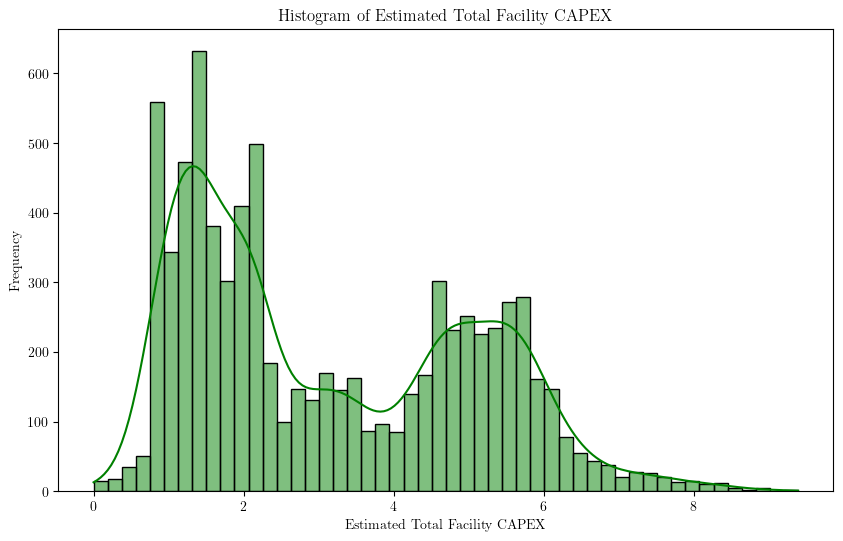

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(subset['log_Estimated_Total_Facility_CAPEX'], bins=50, kde=True, color='green')
plt.title('Histogram of Estimated Total Facility CAPEX')
plt.xlabel('Estimated Total Facility CAPEX')
plt.ylabel('Frequency')
plt.show()

In [65]:
Y = subset['log_Estimated_Total_Facility_CAPEX']
X = subset.drop([
    'log_Estimated_Total_Facility_CAPEX', 
    'Announcement_Date', 
    'Latitude', 
    'Longitude', 
    'US Representative Party_Democratic', # 99% collinear with T
    'US Representative Party_Republican', 
    'US Senator 1: Party_Democratic', # to much collinearity
    'US Senator 1: Party_Republican', # to much collinearity
    'US Senator 2: Party_Democratic', # to much collinearity
    'US Senator 2: Party_Republican', # to much collinearity
    ], axis=1)
T = subset['US Representative Party_Republican'] # run with democrat and republican

mask_1 = ~Y.isna()
Y = Y[mask_1]
X = X[mask_1]
T = T[mask_1]
W = W[mask_1]
mask_2 = ~X[SELECT].isna().any(axis=1)
Y = Y[mask_2]
X = X[mask_2]
T = T[mask_2]
W = W[mask_2]

# get clusters for later
clusters = X['CD119_2024_Name'].values
X = X.drop('CD119_2024_Name', axis=1)

Propensity‐score histogram & trimming: makes assumption 2 of CF explicit, avoids overtrimming

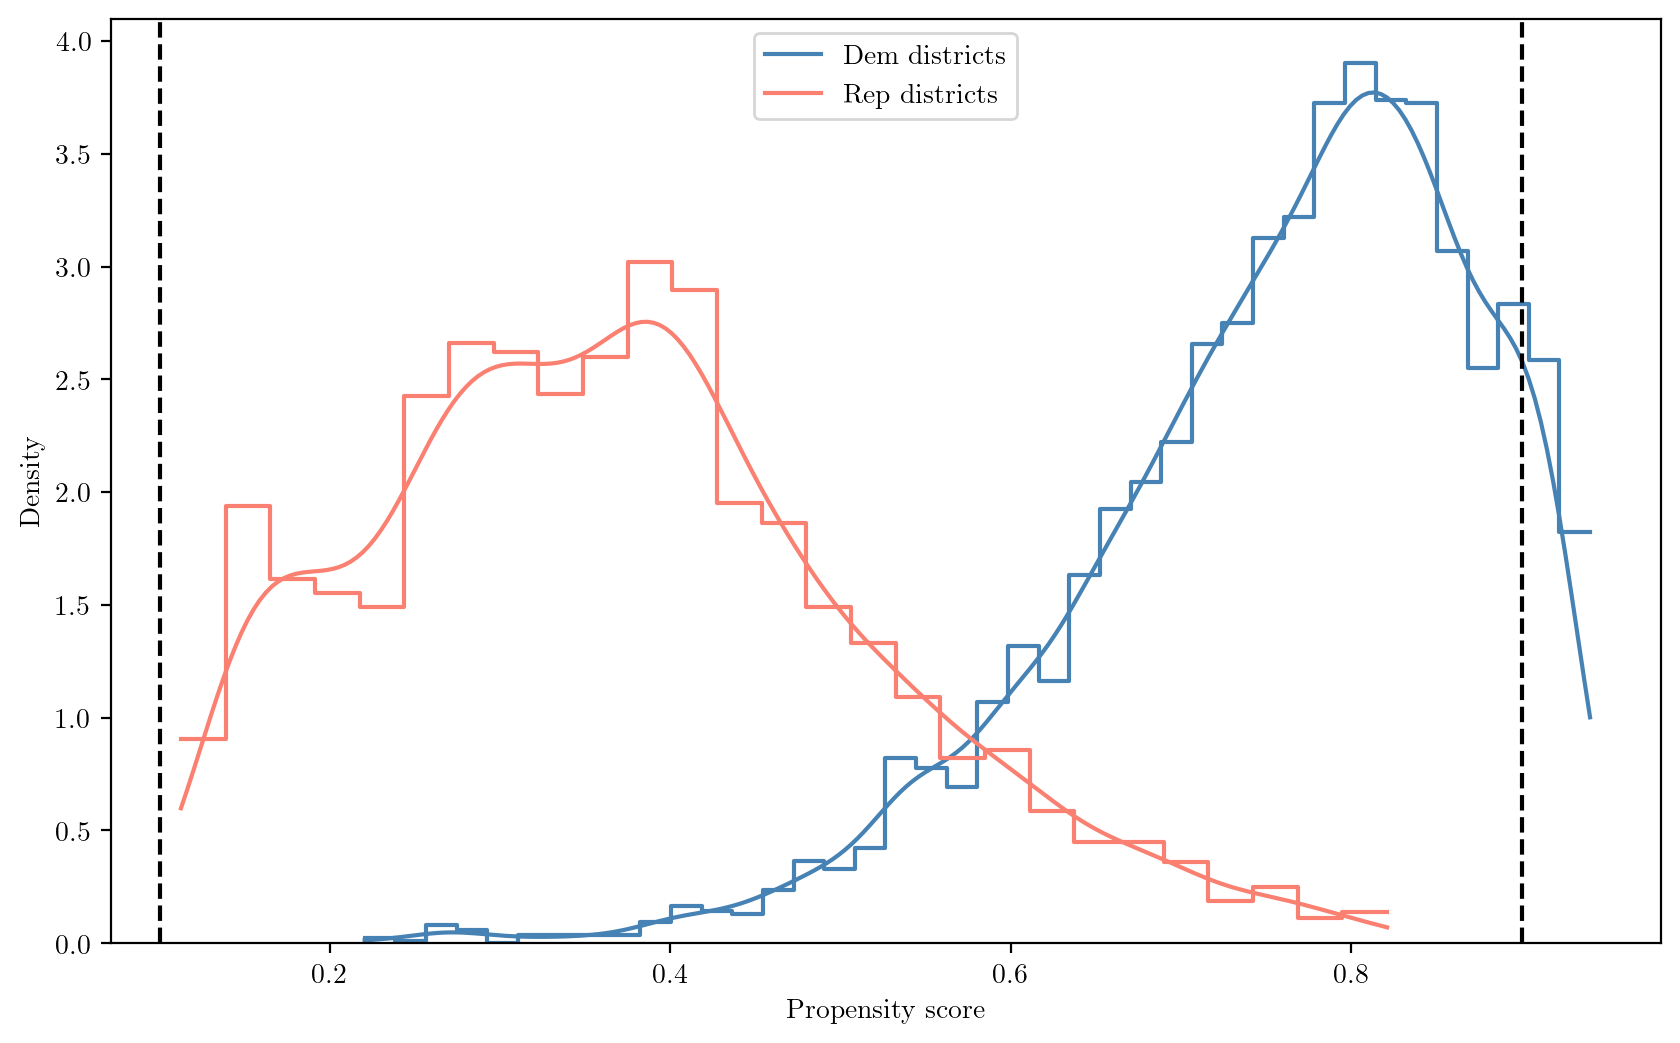

421 observations trimmed for lack of overlap
421 of 7793 obs (5.4%) outside [0.10,0.90]


In [66]:
# Overlap must be checked before CF is fit, 
# oherwise we risk training on observations that require extrapolation

ft = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=10,
        random_state=18,
    )

# Predicted probabilities of every observation
skf   = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
p_hat = cross_val_predict(ft, X, T, cv=skf, method="predict_proba")[:, 1] 

# gives nearly unbiased propensity estimates for the overlap plot 
# and trimming rule without leaking the test fold into the training folds

fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
sns.histplot(p_hat[T==1], color="steelblue", label="Dem districts",
             stat="density", kde=True, element="step", fill=False)
sns.histplot(p_hat[T==0], color="salmon",  label="Rep districts",
             stat="density", kde=True, element="step", fill=False)
plt.axvline(0.10, ls="--", c="k")
plt.axvline(0.90, ls="--", c="k")
# plt.title("Propensity-score overlap check")
plt.xlabel("Propensity score")
plt.legend()
plt.savefig('figures/Methods/overlap_check.png', dpi=200)
plt.show()

# Trim observations with p_hat < 0.10 or p_hat > 0.90 to reduce bias
mask_trim = (p_hat > 0.1) & (p_hat < 0.90)
print(f"{(~mask_trim).sum()} observations trimmed for lack of overlap")

X_trim = X[mask_trim].reset_index(drop=True)
Y_trim = Y[mask_trim].reset_index(drop=True)
T_trim = T[mask_trim].reset_index(drop=True)
W_trim = W[mask_trim].reset_index(drop=True)
clusters_trim = clusters[mask_trim]

ft.fit(X, T) # for later
trimmed = (~mask_trim).sum()
print(f"{trimmed} of {len(T)} obs ({trimmed/len(T)*100:.1f}%) outside [0.10,0.90]") # Note: 5 percent trimmed

In [67]:
# check NaN values in numeric columns
num_cols = X.select_dtypes(include=[np.number]).columns
X_num = X[num_cols]
X[num_cols].isna().sum()

solar_irradiance        0
wind_speed_2m           0
wind_speed_2m_max       0
wind_speed_50m          0
air_temp_2m             0
air_temp_2m_max         0
air_temp_2m_min         0
precipitation           0
med_household_income    0
unemployed              0
total_pop               0
gini                    0
dtype: int64

In [68]:
# multicollinearity with Variance Inflation Factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_num.values, i)
    for i in range(X_num.shape[1])
]
# Sort by highest VIF
print(vif_data.sort_values("VIF", ascending=False).head(20))

                 Feature           VIF
4            air_temp_2m  14273.507155
5        air_temp_2m_max   5384.102641
6        air_temp_2m_min   2115.586870
1          wind_speed_2m    752.543100
2      wind_speed_2m_max    585.441248
11                  gini    348.514334
3         wind_speed_50m    316.496373
0       solar_irradiance    313.764203
10             total_pop    226.264747
9             unemployed     24.560595
8   med_household_income     21.265053
7          precipitation     15.597942


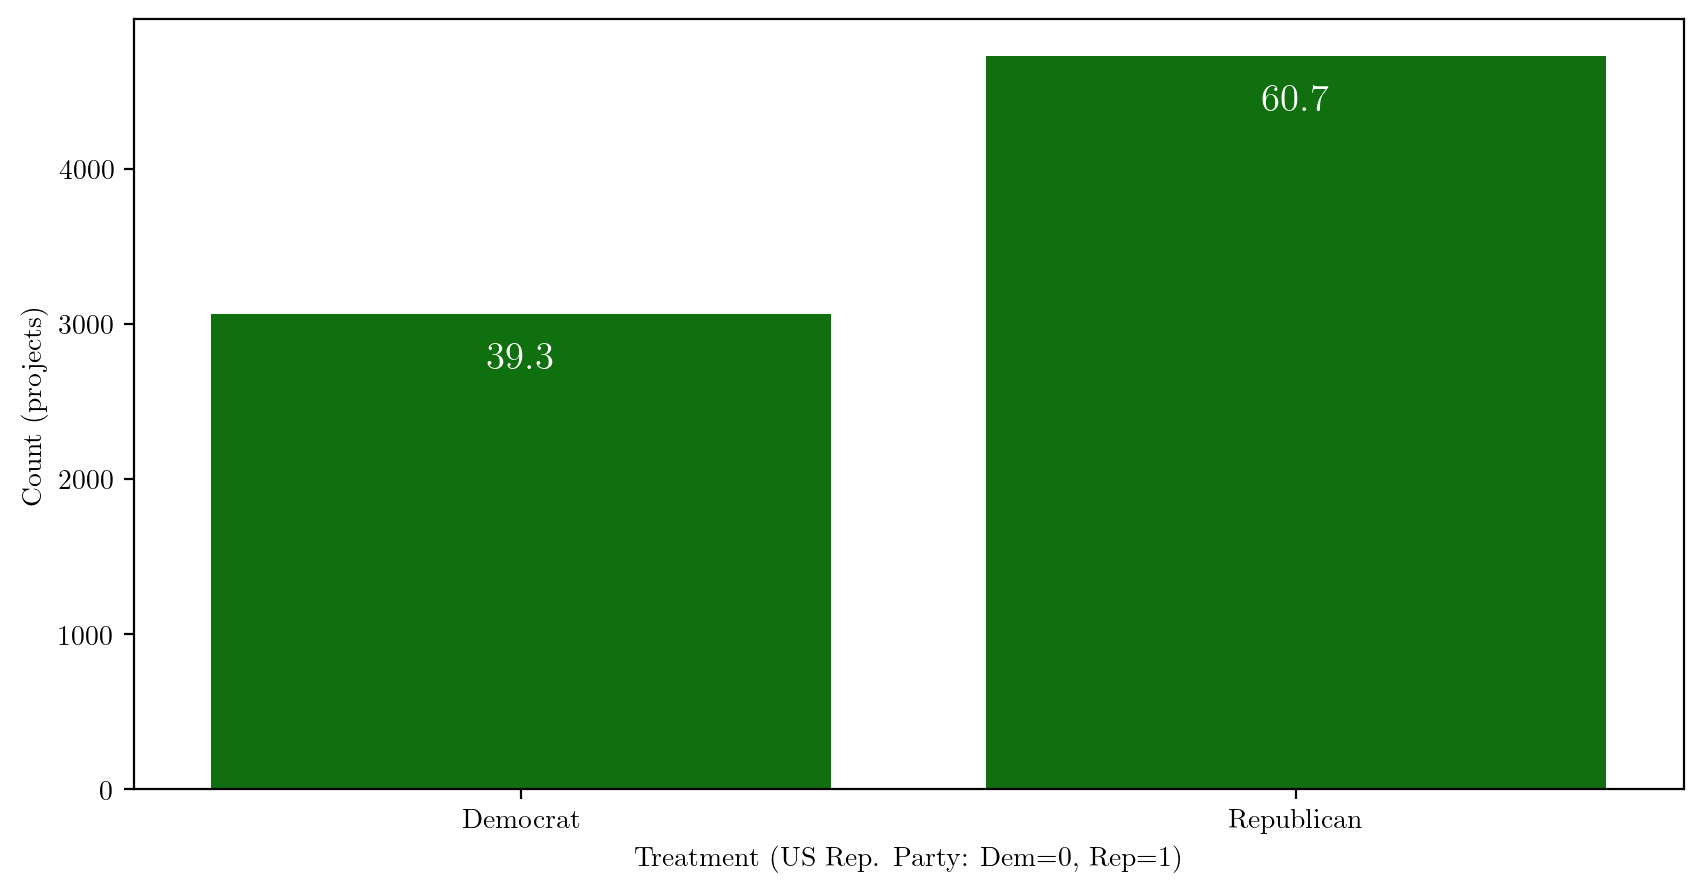

In [69]:
# Distribution of T
plt.figure(figsize=(10,5), dpi=200)
sns.countplot(x=T, color='green')
plt.xlabel("Treatment (US Rep. Party: Dem=0, Rep=1)")
plt.ylabel("Count (projects)")
plt.xticks([0, 1], ['Democrat', 'Republican'])
# plt.title("Distribution of Treatment (U.S. Rep. Party)")
total = len(T)
for i in range(2):
    percentage = (T == i).sum() / total * 100
    plt.text(i, (T == i).sum() - 400, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=14, color='white')
plt.savefig('figures/Methods/treatment_distribution.png', dpi=200)
plt.show()

In [79]:
# Summary stats: Table A.1
statistics = subset_master[mask_1]
statistics = statistics[mask_2]
statistics = statistics[mask_trim]

statistics = statistics.drop(['Latitude', 'Longitude'], axis=1)
unique_cd = statistics['CD119_2024_Name'].nunique()
print(f"Number of unique CD119_2024_Name: {unique_cd}")
unique_states = statistics['State'].nunique()
print(f"Number of unique states: {unique_states}")

summary_stats = statistics.describe().T
summary_stats = summary_stats[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
# round all values to 2 decimal places
summary_stats = summary_stats.round(2)
summary_stats

Number of unique CD119_2024_Name: 396
Number of unique states: 44


mean       std        min         max  \
Estimated_Total_Facility_CAPEX     136.60    439.09       0.00    11951.80   
Announcement_Year                 2020.89      2.23    2013.00     2024.00   
Announcement_Quarter                 2.46      1.12       1.00        4.00   
solar_irradiance                     4.49      0.69       3.47        6.08   
wind_speed_2m                        2.02      1.18       0.05        6.00   
wind_speed_2m_max                    3.21      1.76       0.24        8.33   
wind_speed_50m                       5.39      1.05       3.03        8.87   
air_temp_2m                         14.19      4.96       0.04       26.07   
air_temp_2m_max                     20.05      5.59       7.20       33.22   
air_temp_2m_min                      8.89      4.92      -6.70       25.05   
precipitation                        2.52      1.38       0.17        6.53   
med_household_income             70419.95  18496.50   34351.00   227969.50   
unemployed                       20350.13   4887.79    7432.00    50885.00   
total_pop                       748438.53  49271.47  523501.00  1038197.00   
gini                                 0.46      0.02       0.37        0.56   

                                      25%        50%        75%  
Estimated_Total_Facility_CAPEX       3.33      10.94     125.51  
Announcement_Year                 2019.00    2021.00    2023.00  
Announcement_Quarter                 1.00       2.00       3.00  
solar_irradiance                     3.92       4.30       4.98  
wind_speed_2m                        0.92       2.21       2.98  
wind_speed_2m_max                    1.36       3.77       4.65  
wind_speed_50m                       4.55       5.23       6.31  
air_temp_2m                         10.12      13.38      18.01  
air_temp_2m_max                     15.36      19.21      24.97  
air_temp_2m_min                      5.00       8.47      12.42  
precipitation                        1.27       2.69       3.45  
med_household_income             57354.00   68016.50   79860.00  
unemployed                       17110.00   19767.00   22734.00  
total_pop                       718415.00  753463.00  777093.00  
gini                                 0.44       0.46       0.47

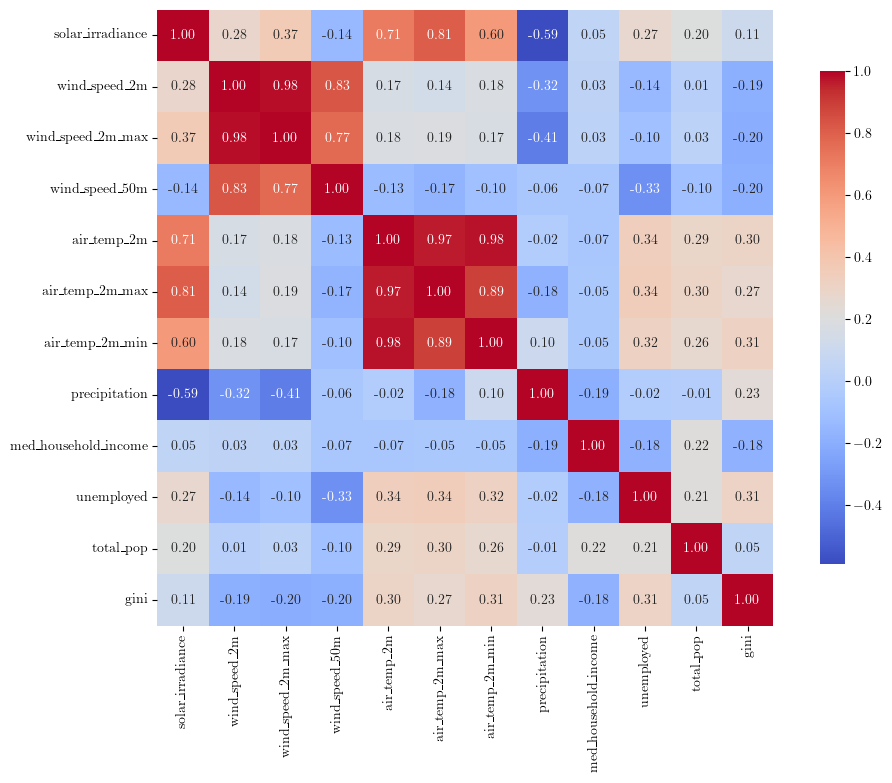

In [ ]:
# Check correlation of continuous variables, Fig. A.6
plt.figure(figsize=(12, 8))
sns.heatmap(X_num.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Matrix of Numeric Variables")
plt.savefig('figures/Methods/correlation_matrix_num.png', dpi=200, bbox_inches='tight')
plt.show()

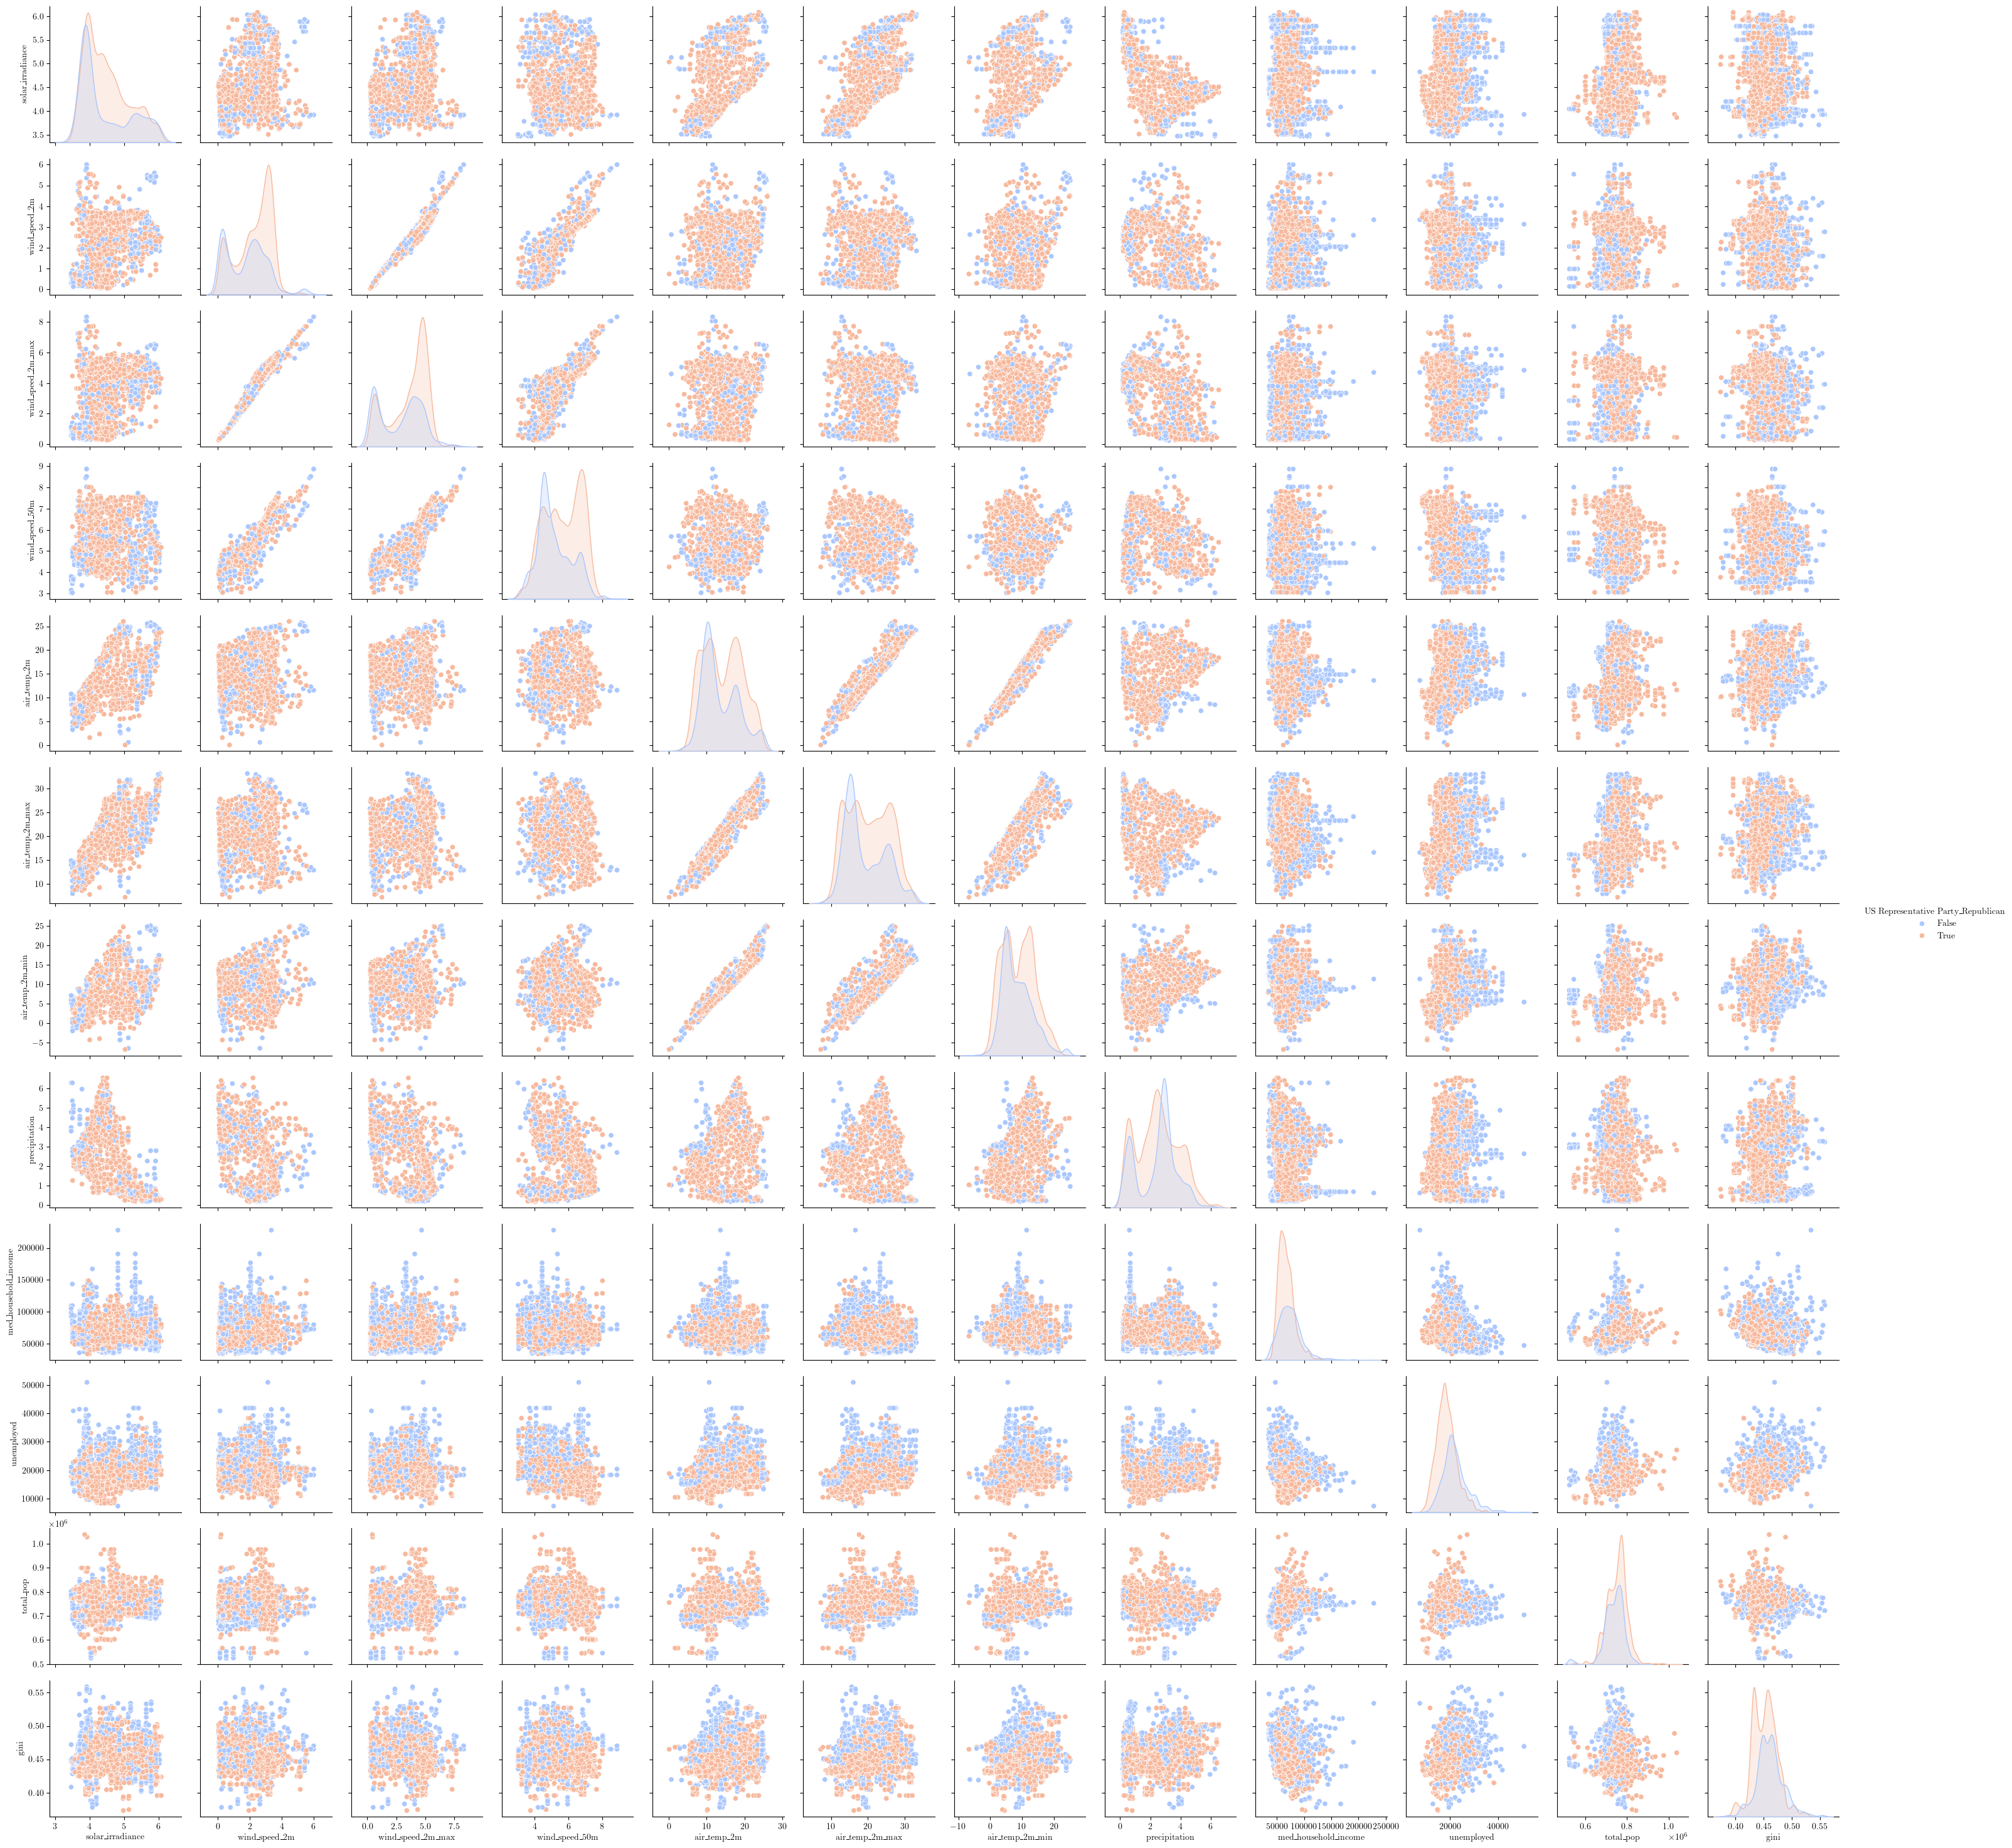

In [89]:
# Check collinearity of numeric variables, Fig. A.7
sample_cols = X_num.columns  # adjust as needed
sns.pairplot(pd.concat([X_num[sample_cols], T], axis=1), hue='US Representative Party_Republican', palette='coolwarm')
# no legend
plt.savefig('figures/Methods/pairplot_num.png', dpi=300)
plt.show()

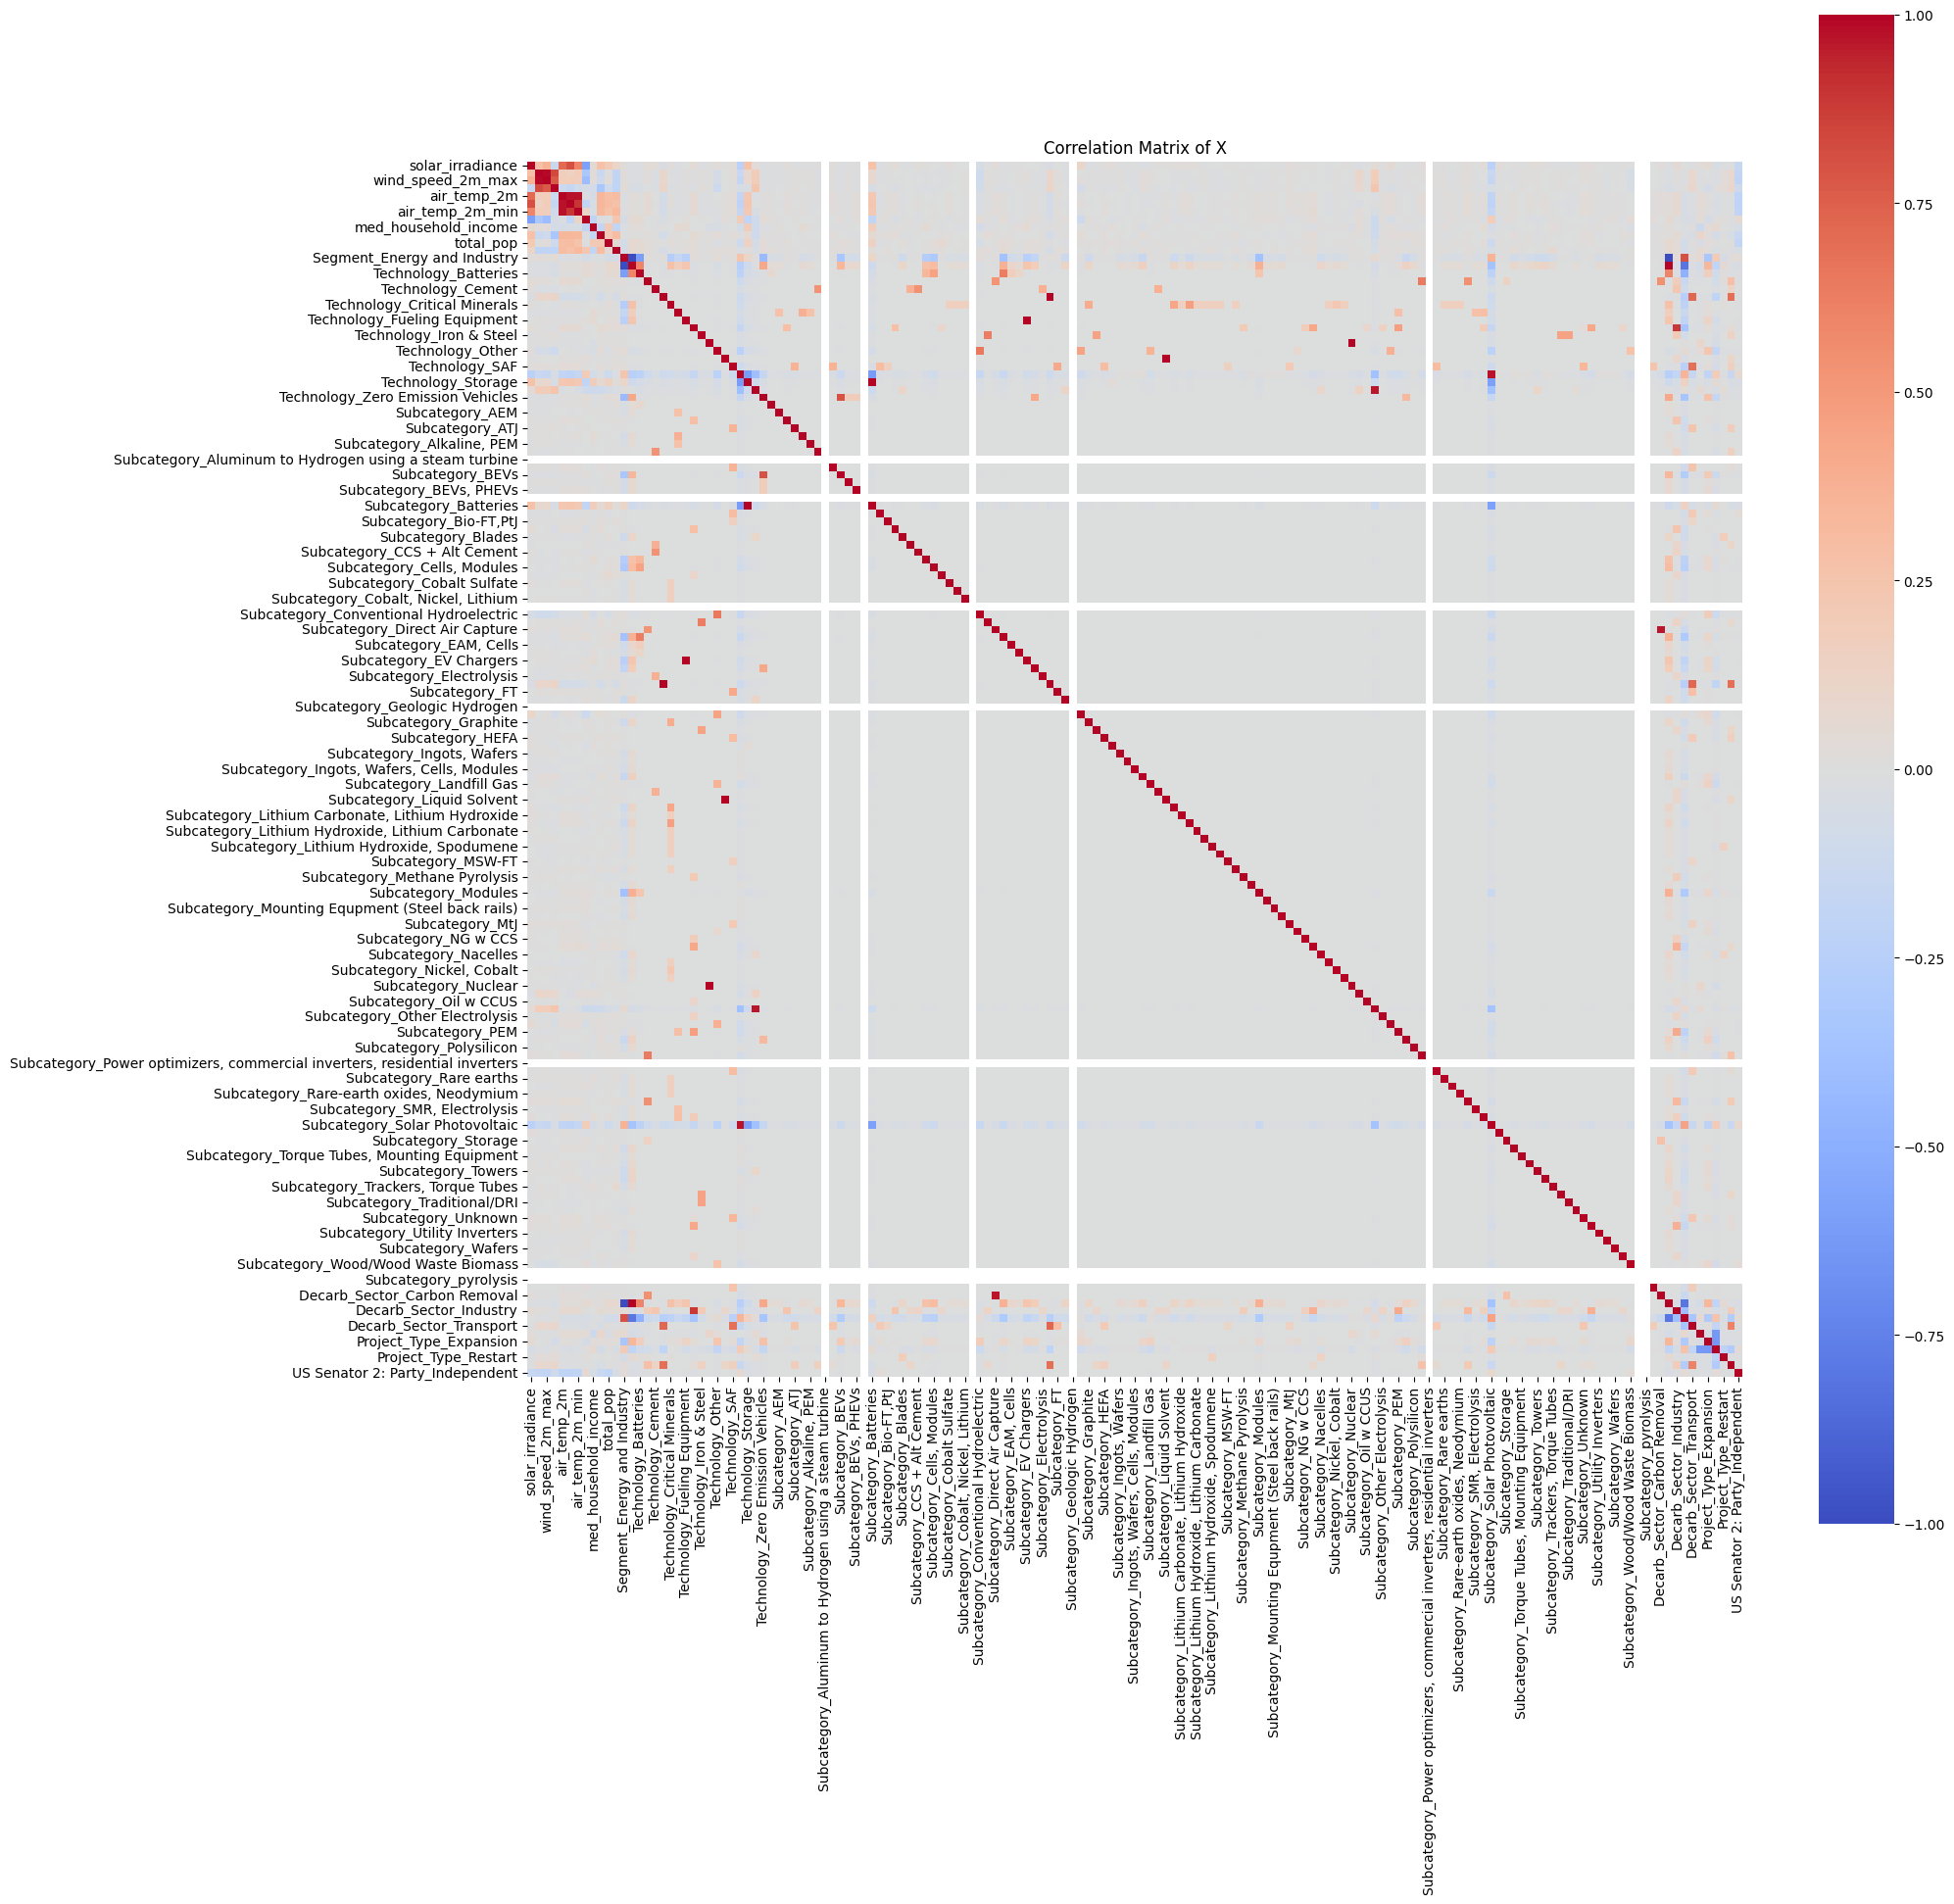

In [ ]:
# correlation matrix of all of X
corr = X.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap='coolwarm', square=True)
# plt.title('Correlation Matrix of X')
plt.savefig('figures/Methods/correlation_matrix_X.png', dpi=200)
plt.show()

invalid value encountered in divide
invalid value encountered in divide


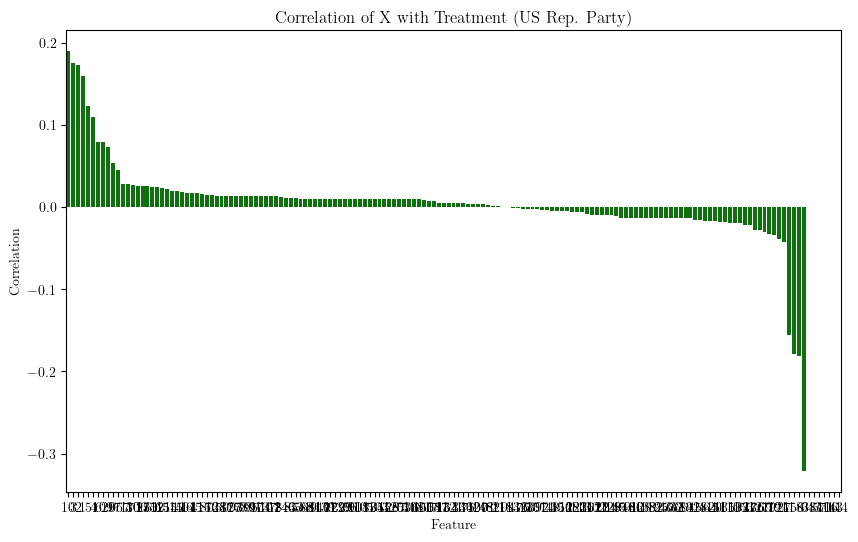

In [101]:
# compute corr(X, T) (dropped those that were collinear above), Fig. A.8
correlation_copy = X_trim.copy()
# make column names numeric
correlation_copy.columns = [f"{i}" for i in range(correlation_copy.shape[1])]

corr_X_T = correlation_copy.corrwith(T_trim)
corr_X_T = corr_X_T.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_X_T.index, y=corr_X_T.values, color='green')
plt.title('Correlation of X with Treatment (US Rep. Party)')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.xticks(range(len(corr_X_T.index)), corr_X_T.index, rotation=0)
plt.savefig('figures/Methods/correlation_X_T.png', dpi=200)
plt.show()

In [70]:
# get outliers of corr
outliers = corr_X_T[abs(corr_X_T) > 0.3]
print("Outliers:")
print(outliers)

Outliers:
unemployed   -0.358081
dtype: float64


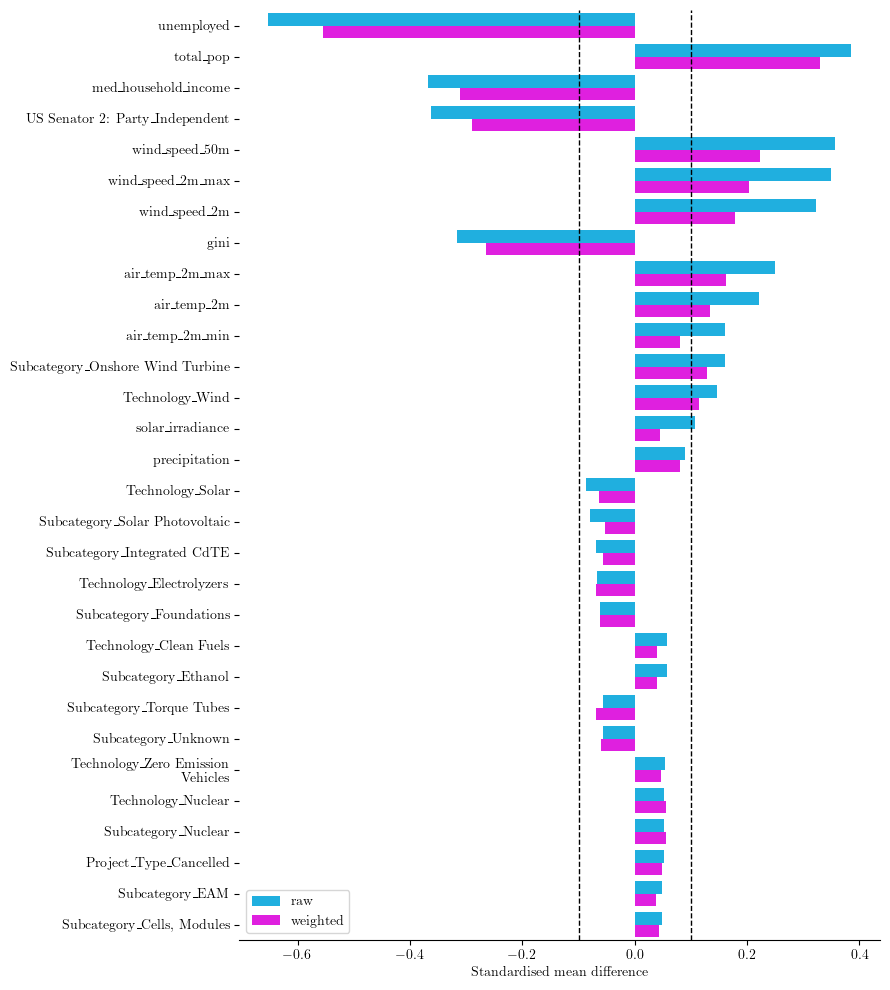

7.6% of covas still exceed |0.10| after weighting


In [ ]:
# Standardised mean differences to assess balance,Fig. A.4

# Compute p̂(X) for trimmed sample: out-of-fold predictions
# (sometimes p_hat_trim already assigned)
try:
    p_hat_trim
except NameError:
    p_hat_trim = ft.predict_proba(X_trim)[:, 1] # shape (n_trim,)

w_ipw = np.where(T_trim == 1, 1 / p_hat_trim, 1 / (1 - p_hat_trim)) # IPW weights

mean_t = X_trim[T_trim == 1].mean() 
mean_c = X_trim[T_trim == 0].mean()
std_all = X_trim.std(ddof=0) # pooled stdev

smd_raw = (mean_t - mean_c) / std_all

# E[X|T=1] under IPW=Σw_i X_i / Σ w_i (within treated)
mean_t_w = (X_trim.mul(w_ipw * (T_trim == 1), axis=0).sum()
           / w_ipw[T_trim == 1].sum())

mean_c_w = (X_trim.mul(w_ipw * (T_trim == 0), axis=0).sum()
           / w_ipw[T_trim == 0].sum())

smd_w    = (mean_t_w - mean_c_w) / std_all # weighted SMD

smd_df = (pd.concat([smd_raw.rename("raw"),
                     smd_w.rename("weighted")], axis=1)
            .assign(abs_raw=lambda d: d["raw"].abs())
            .sort_values("abs_raw", ascending=False))

show = (smd_df.head(30) # 30 worst covariates
               .drop(columns="abs_raw")
               .reset_index()
               .melt(id_vars="index", value_name="smd", var_name="type"))

show["index"] = show["index"].apply(lambda s: "\n".join(textwrap.wrap(s, 32)))

plt.figure(figsize=(9, 10))
sns.barplot(data=show,
            y="index", x="smd", hue="type",
            dodge=True, palette={"raw": "deepskyblue", "weighted": "fuchsia"})
plt.axvline(0.10, ls="--", lw=1, c="k"); plt.axvline(-0.10, ls="--", lw=1, c="k")
plt.xlabel("Standardised mean difference"); plt.ylabel("")
# plt.title("Largest covariate imbalances (raw vs IP-weighted)")
plt.legend(title="")
sns.despine(left=True)
plt.tight_layout()
plt.savefig('figures/Methods/smd.png', dpi=300)
plt.show()

pct_big = (smd_w.abs() > .10).mean()*100
print(f"{pct_big:.1f}% of covas still exceed |0.10| after weighting")

--> Use trimmed values from here on

invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'


Residual T-Y correlation:  0.0488
t-stat (n=7372):  4.19
p-value:  0.0000


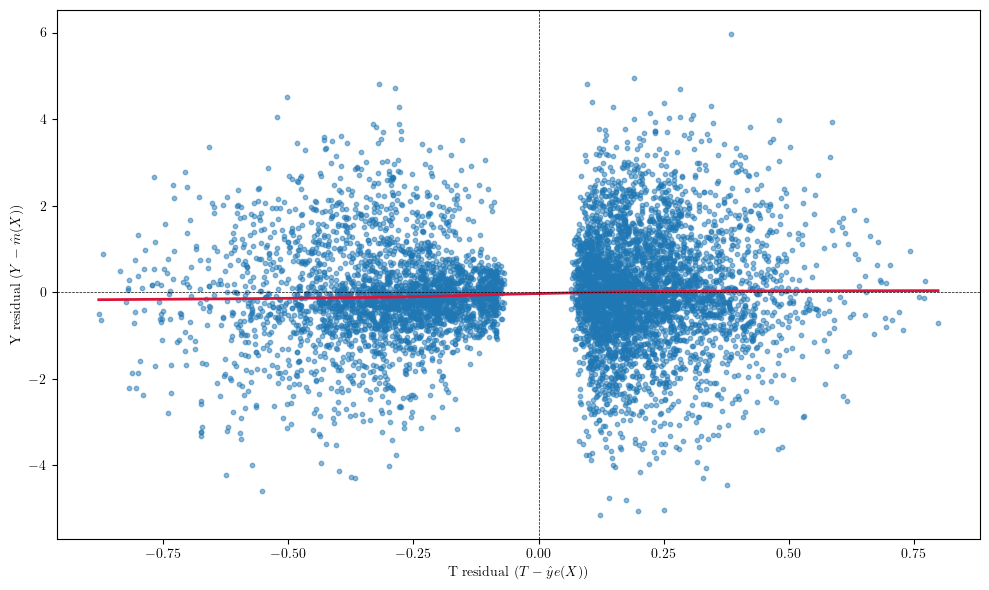

In [84]:
# Residual independence test (see Chernozhukov et al., 2018), Fig. A.5
m_Y = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, random_state=18)
m_T = RandomForestClassifier(n_estimators=300, min_samples_leaf=5, random_state=18)
cv = KFold(n_splits=5, shuffle=True, random_state=18)
m_hat = cross_val_predict(m_Y, X_trim, Y_trim, cv=cv) # this is E[Y|X]
e_hat = cross_val_predict(m_T, X_trim, T_trim, cv=cv, method="predict_proba")[:, 1] # this is P(T=1|X)

Y_tilde = Y_trim - m_hat
T_tilde = T_trim - e_hat

corr = np.corrcoef(T_tilde, Y_tilde)[0, 1]
n = len(Y_tilde)
t_stat = corr * np.sqrt((n - 2) / (1 - corr**2))
p_val = 2 * stats.t.sf(np.abs(t_stat), df=n - 2)

print(f"Residual T-Y correlation: {corr: .4f}")
print(f"t-stat (n={n}): {t_stat: .2f}")
print(f"p-value: {p_val: .4f}")

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.regplot(x=T_tilde, y=Y_tilde, lowess=True, scatter_kws=dict(alpha=.5, s=10), 
            line_kws=dict(color='crimson', linewidth=2))
plt.xlabel("T residual $(T-\hat{y} e (X))$") 
plt.ylabel("Y residual $(Y-\hat{m}(X))$") 
# plt.title("Residual-independence test")
plt.axhline(0, c='k', ls='--', lw=0.5)
plt.axvline(0, c='k', ls='--', lw=0.5)
plt.tight_layout()
plt.savefig('figures/Methods/residual_independence_test.png', dpi=300)
plt.show()

In [97]:
# Cleanup: drop any nans in X_trim, Y_trim, T_trim, W_trim
mask = ~X_trim.isna().any(axis=1)
X_trim = X_trim[mask]
Y_trim = Y_trim[mask]
T_trim = T_trim[mask]
W_trim = W_trim[mask]
clusters_trim = clusters_trim[mask]
print(f"Final sample size: {len(X_trim)}")

Final sample size: 7372


Baseline Causal Forest

In [102]:
# clusters provided at beginning
modelY = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, random_state=randomState)
modelT = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, random_state=randomState)

CF_KWARGS = dict(
    model_y = modelY,
    model_t = modelT,
    n_estimators = 300,
    min_samples_leaf = 10,
    max_depth = None,
    random_state = randomState,
    inference = "bootstrap",
    verbose = 0
)

causal_forest = CausalForestDML(**CF_KWARGS)

causal_forest.fit(
    Y=Y_trim.values, 
    T=T_trim.values, 
    X=X_trim.values, 
    W=W_trim.values,
    groups=clusters_trim,
)

cate_preds = causal_forest.effect(X_trim.values)
lb, ub = causal_forest.effect_interval(X_trim.values, alpha=0.05) 

Coarse grid search

    n_estimators  min_samples_leaf  max_depth  heterogeneity  avg_ci_width
0            100                 5        NaN       0.189063      1.476253
1            300                 5        NaN       0.175378      1.187493
2            100                10        NaN       0.139076      1.027067
3            300                10        NaN       0.133175      0.863882
4            100                20        NaN       0.108047      0.748209
5            300                20        NaN       0.104365      0.652001
6            100                 5        5.0       0.062875      0.499519
7            300                 5        5.0       0.062139      0.453493
8            100                10        5.0       0.063611      0.467830
9            300                10        5.0       0.061715      0.439856
10           100                20        5.0       0.061321      0.437574
11           300                20        5.0       0.060575      0.418154
12           100         

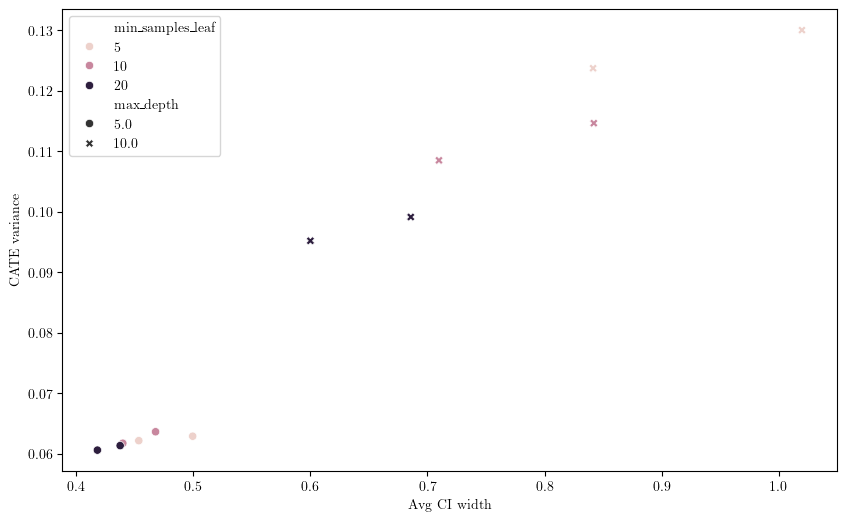

In [ ]:
# only for appendix, Table A.2
param_grid = {
    'n_estimators': [100, 300],
    'min_samples_leaf': [5, 10, 20],
    'max_depth': [None, 5, 10],
}

results = []
for params in ParameterGrid(param_grid):
    modelY = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, 
        random_state=randomState)
    modelT = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, 
        random_state=randomState)
    
    cf = CausalForestDML(
        model_y=modelY,
        model_t=modelT,
        n_estimators=params['n_estimators'],
        min_samples_leaf=params['min_samples_leaf'],
        max_depth=params['max_depth'],
        random_state=randomState,
        inference='bootstrap',
    )
    cf.fit(Y_trim, T_trim, X=X_trim, W=W_trim, groups=clusters_trim)
    te = cf.effect(X)
    hetero = np.var(te)
    lb, ub = cf.effect_interval(X_trim, alpha=0.05)
    avg_width = np.mean(ub - lb)
    results.append({
        'n_estimators': params['n_estimators'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'heterogeneity': hetero,
        'avg_ci_width': avg_width,
    })
results_df = pd.DataFrame(results)
print(results_df)

# get signal-to-noise ratio (heterogeneity/avg_ci_width)
g = results_df.copy()
g["sn_ratio"] = g["heterogeneity"] / g["avg_ci_width"]
print(g.sort_values("sn_ratio", ascending=False).head(5))

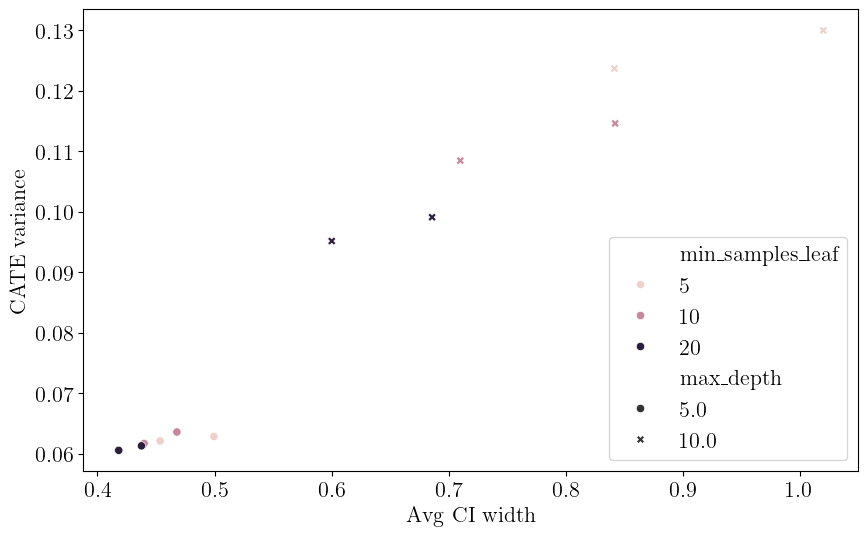

In [108]:
# set font size
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.scatterplot(data=g, x="avg_ci_width", y="heterogeneity", 
                hue="min_samples_leaf", style="max_depth")
plt.xlabel("Avg CI width")
plt.ylabel("CATE variance")
# plt.title("Heterogeneity–precision trade-off")
plt.savefig('figures/Methods/heterogeneity_precision_tradeoff.png', dpi=200)
plt.show()

In [110]:
# Use CF_MAIN below
best_params = dict(n_estimators=300, min_samples_leaf=10, max_depth=None) # from grid search
CF_MAIN = CausalForestDML(**CF_KWARGS | best_params).fit(
              Y_trim.values, T_trim.values,
              X=X_trim.values, groups=clusters_trim)

cate_preds = CF_MAIN.effect(X_trim.values)
lb, ub = CF_MAIN.effect_interval(X_trim.values, alpha=0.05) 

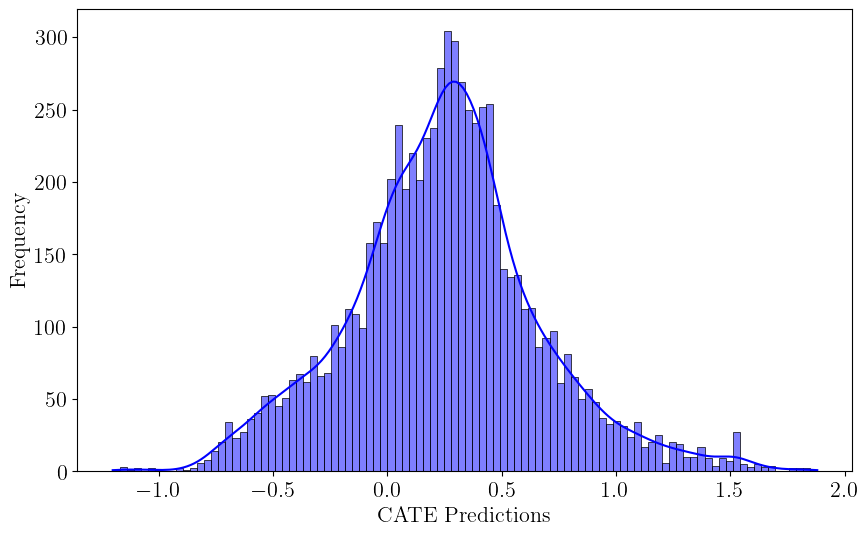

In [117]:
# hist of cate_preds
plt.figure(figsize=(10, 6))
sns.histplot(cate_preds, bins=100, kde=True, color='blue')
# plt.title('Histogram of CATE Predictions')
plt.xlabel('CATE Predictions')
plt.ylabel('Frequency')
plt.savefig('figures/Results/histogram_cate_preds.png', dpi=200)
plt.show()

## Optimization/Calibration

In [ ]:
cf_base = causal_forest
Xb, Yb, Tb, Gb = X_trim.values, Y_trim.values, T_trim.values, clusters_trim
unique_g = np.unique(Gb)
B   = 500
rng = np.random.default_rng(randomState)
ate_boot = np.empty(B)

future_to_mask = {}
with ThreadPoolExecutor(max_workers=8) as executor: # max. 8
    for _ in range(B):
        draw  = rng.choice(unique_g, size=len(unique_g), replace=True)
        mask  = np.isin(Gb, draw)
        cf_b  = CausalForestDML(**CF_KWARGS | best_params)
        fut   = executor.submit(cf_b.fit,Yb[mask], Tb[mask],
                                X=Xb[mask], groups=Gb[mask])
        future_to_mask[fut] = mask.copy()
    for i, fut in enumerate(tqdm(as_completed(future_to_mask),
                                 total=B, desc="Bootstrapping")):
        cf_b = fut.result()
        mask = future_to_mask[fut]
        ate_boot[i] = cf_b.ate(Xb[mask])  

se_boot = ate_boot.std(ddof=1)
ci_lower  = np.percentile(ate_boot, 2.5)
ci_upper  = np.percentile(ate_boot, 97.5)
ate_base = cf_base.ate(Xb)
lb_base, ub_base   = cf_base.ate_interval(Xb)
print(f"Baseline ATE (IJ s.e.): {ate_base:.4f} [{lb_base:.4f}, {ub_base:.4f}]")
print(f"Cluster bootstrap results (B = {B})")
print(f"ATE point estimate: {ate_base: .4f}") # how much outcome is expected to change if everyone had a Republican rep
print(f"Bootstrap SE: {se_boot: .4f}")
print(f"95% percentile CI: [{ci_lower: .4f}, {ci_upper: .4f}]") # need to add to paper

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


: 

In [113]:
# Random permutation of treatment within clusters
np.random.seed(randomState)
T_perm = (pd.Series(T_trim).groupby(clusters_trim)
            .transform(np.random.permutation).values)

cf_perm = CausalForestDML(**CF_KWARGS)
cf_perm.fit(Y_trim.values, T_perm,X=X_trim.values, groups=clusters_trim)
ate_perm = cf_perm.ate(X_trim.values)
print(f"Permutation placebo ATE (expected around 0): {ate_perm:.4f}")

Permutation placebo ATE (expected around 0): 0.2485


In [ ]:
# Sensitivity to treatment definition - Table A.
# robustness to alternative political measures/potential endogeneity

T_house = T_trim.copy()
both_rep = (subset.loc[X_trim.index, 'US Senator 1: Party_Republican'] == 1) & \
           (subset.loc[X_trim.index, 'US Senator 2: Party_Republican'] == 1)
T_senate = both_rep.astype(int).values

treatments = {
    "House (Rep=1)": T_house,
    "Senate (both Rep)": T_senate
}

results = []
for name, T_alt in treatments.items():
    cf_alt = CausalForestDML(**CF_KWARGS)
    cf_alt.fit(Y_trim.values, T_alt, X=X_trim.values, groups=clusters_trim)
    ate = cf_alt.ate(X_trim.values)
    ci_low, ci_high = cf_alt.ate_interval(X_trim.values)

    results.append({
        "Treatment": name,
        "ATE": ate,
        "CI_low": ci_low,
        "CI_high": ci_high
    })
sens_df = (pd.DataFrame(results).assign(ATE_fmt = lambda d:
                     d.apply(lambda r: f"{r['ATE']:.4f} "
                                        f"[{r['CI_low']:.4f}, {r['CI_high']:.4f}]", axis=1)))
print("\nsensitivity of average treatment effect to coding choice")
print(sens_df[['Treatment', 'ATE_fmt']].to_string(index=False))



sensitivity of average treatment effect to coding choice
        Treatment                   ATE_fmt
    House (Rep=1)  0.2485 [-0.2353, 0.7323]
Senate (both Rep) -0.0277 [-0.4041, 0.3487]


Calibration test

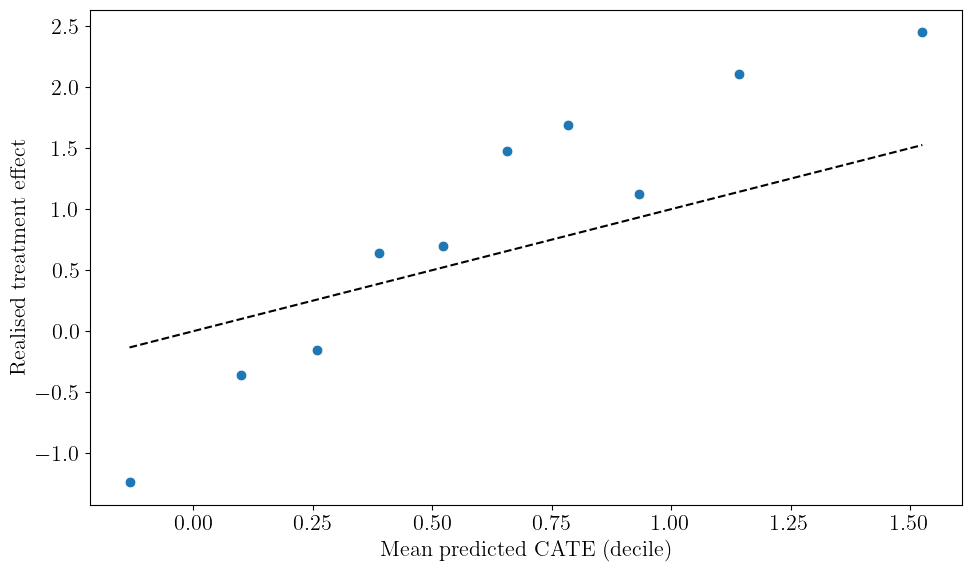

Correlation predicted vs realised across deciles: 0.950


In [115]:
# Causal forest calibration plot, Fig. A.10
X_tr, X_te, Y_tr, Y_te, T_tr, T_te, cl_tr, cl_te = train_test_split(
        X_trim.values, Y_trim.values, T_trim.values, clusters_trim,
        test_size=0.5, stratify=T_trim, random_state=18)

cf_cal = CausalForestDML(**CF_KWARGS | best_params)
cf_cal.fit(Y_tr, T_tr, X=X_tr, groups=cl_tr)
tau_hat = cf_cal.effect(X_te)
df_cal = pd.DataFrame({
        "tau_hat": tau_hat,
        "Y" : Y_te,
        "T" : T_te
})
df_cal["decile"] = pd.qcut(df_cal["tau_hat"], 10, labels=False, duplicates="drop")

# realized vs predicted per decile
mean_Y = (df_cal.groupby(["decile", "T"])["Y"].mean().unstack())
realised  = mean_Y[True] - mean_Y[False]
predicted = df_cal.groupby("decile")["tau_hat"].mean()

plt.figure(figsize=(10,6))
sns.scatterplot(x=predicted, y=realised, s=60)
plt.plot([predicted.min(), predicted.max()], 
         [predicted.min(), predicted.max()], ls="--", c="k")
plt.xlabel("Mean predicted CATE (decile)")
plt.ylabel("Realised treatment effect")
# plt.title("Causal-forest calibration plot")
plt.tight_layout()
plt.savefig('figures/Results/calibration_plot.png', dpi=200)
plt.show()

corr = np.corrcoef(predicted, realised)[0, 1]
print(f"Correlation predicted vs realised across deciles: {corr:.3f}")


Ranking is good: units the forest predicts to have higher τ̂ actually show higher realised treatment effect, Forest under-predicts magnitude: realised uplift is larger than τ̂ on average. That’s common when the honest forest trades bias for variance.

In [ ]:
# 

# Results

In [119]:
if isinstance(X_trim, pd.DataFrame):
    df_res = X_trim.copy()
else:
    feature_names = [f"x{i}" for i in range(X_trim.shape[1])]
    df_res = pd.DataFrame(X_trim, columns=feature_names)

df_res['Y'] = Y_trim
df_res['T'] = T_trim
df_res['cate'] = cate_preds
df_res['ci_low'] = lb
df_res['ci_high'] = ub
ate = df_res['cate'].mean()
std_cate = df_res['cate'].std()
frac_pos = (df_res['cate'] > 0).mean()
print(f"ATE ≈ {ate:.3f}")
print(f"std(CATE) ≈ {std_cate:.3f}")
print(f"% of units with CATE>0: {100*frac_pos:.1f}%")
sig_pos = (df_res['ci_low']  > 0).mean()
sig_neg = (df_res['ci_high'] < 0).mean()
print(f"% significantly positive (CI above zero): {100*sig_pos:.1f}%")
print(f"% significantly negative (CI below zero): {100*sig_neg:.1f}%")

ATE ≈ 0.249
std(CATE) ≈ 0.418
% of units with CATE>0: 75.3%
% significantly positive (CI above zero): 30.5%
% significantly negative (CI below zero): 6.0%


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

RuntimeError: latex was not able to process the following string:
b'Iron & Steel'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpl5hdj6lx ffe90e71f9e78a8033722f64c9e4e1eb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./ffe90e71f9e78a8033722f64c9e4e1eb.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ffe90e71f9e78a8033722f64c9e4e1eb.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.29 {\rmfamily Iron &
                       Steel}%
No pages of output.
Transcript written on tmpl5hdj6lx/ffe90e71f9e78a8033722f64c9e4e1eb.log.




<Figure size 1000x600 with 1 Axes>

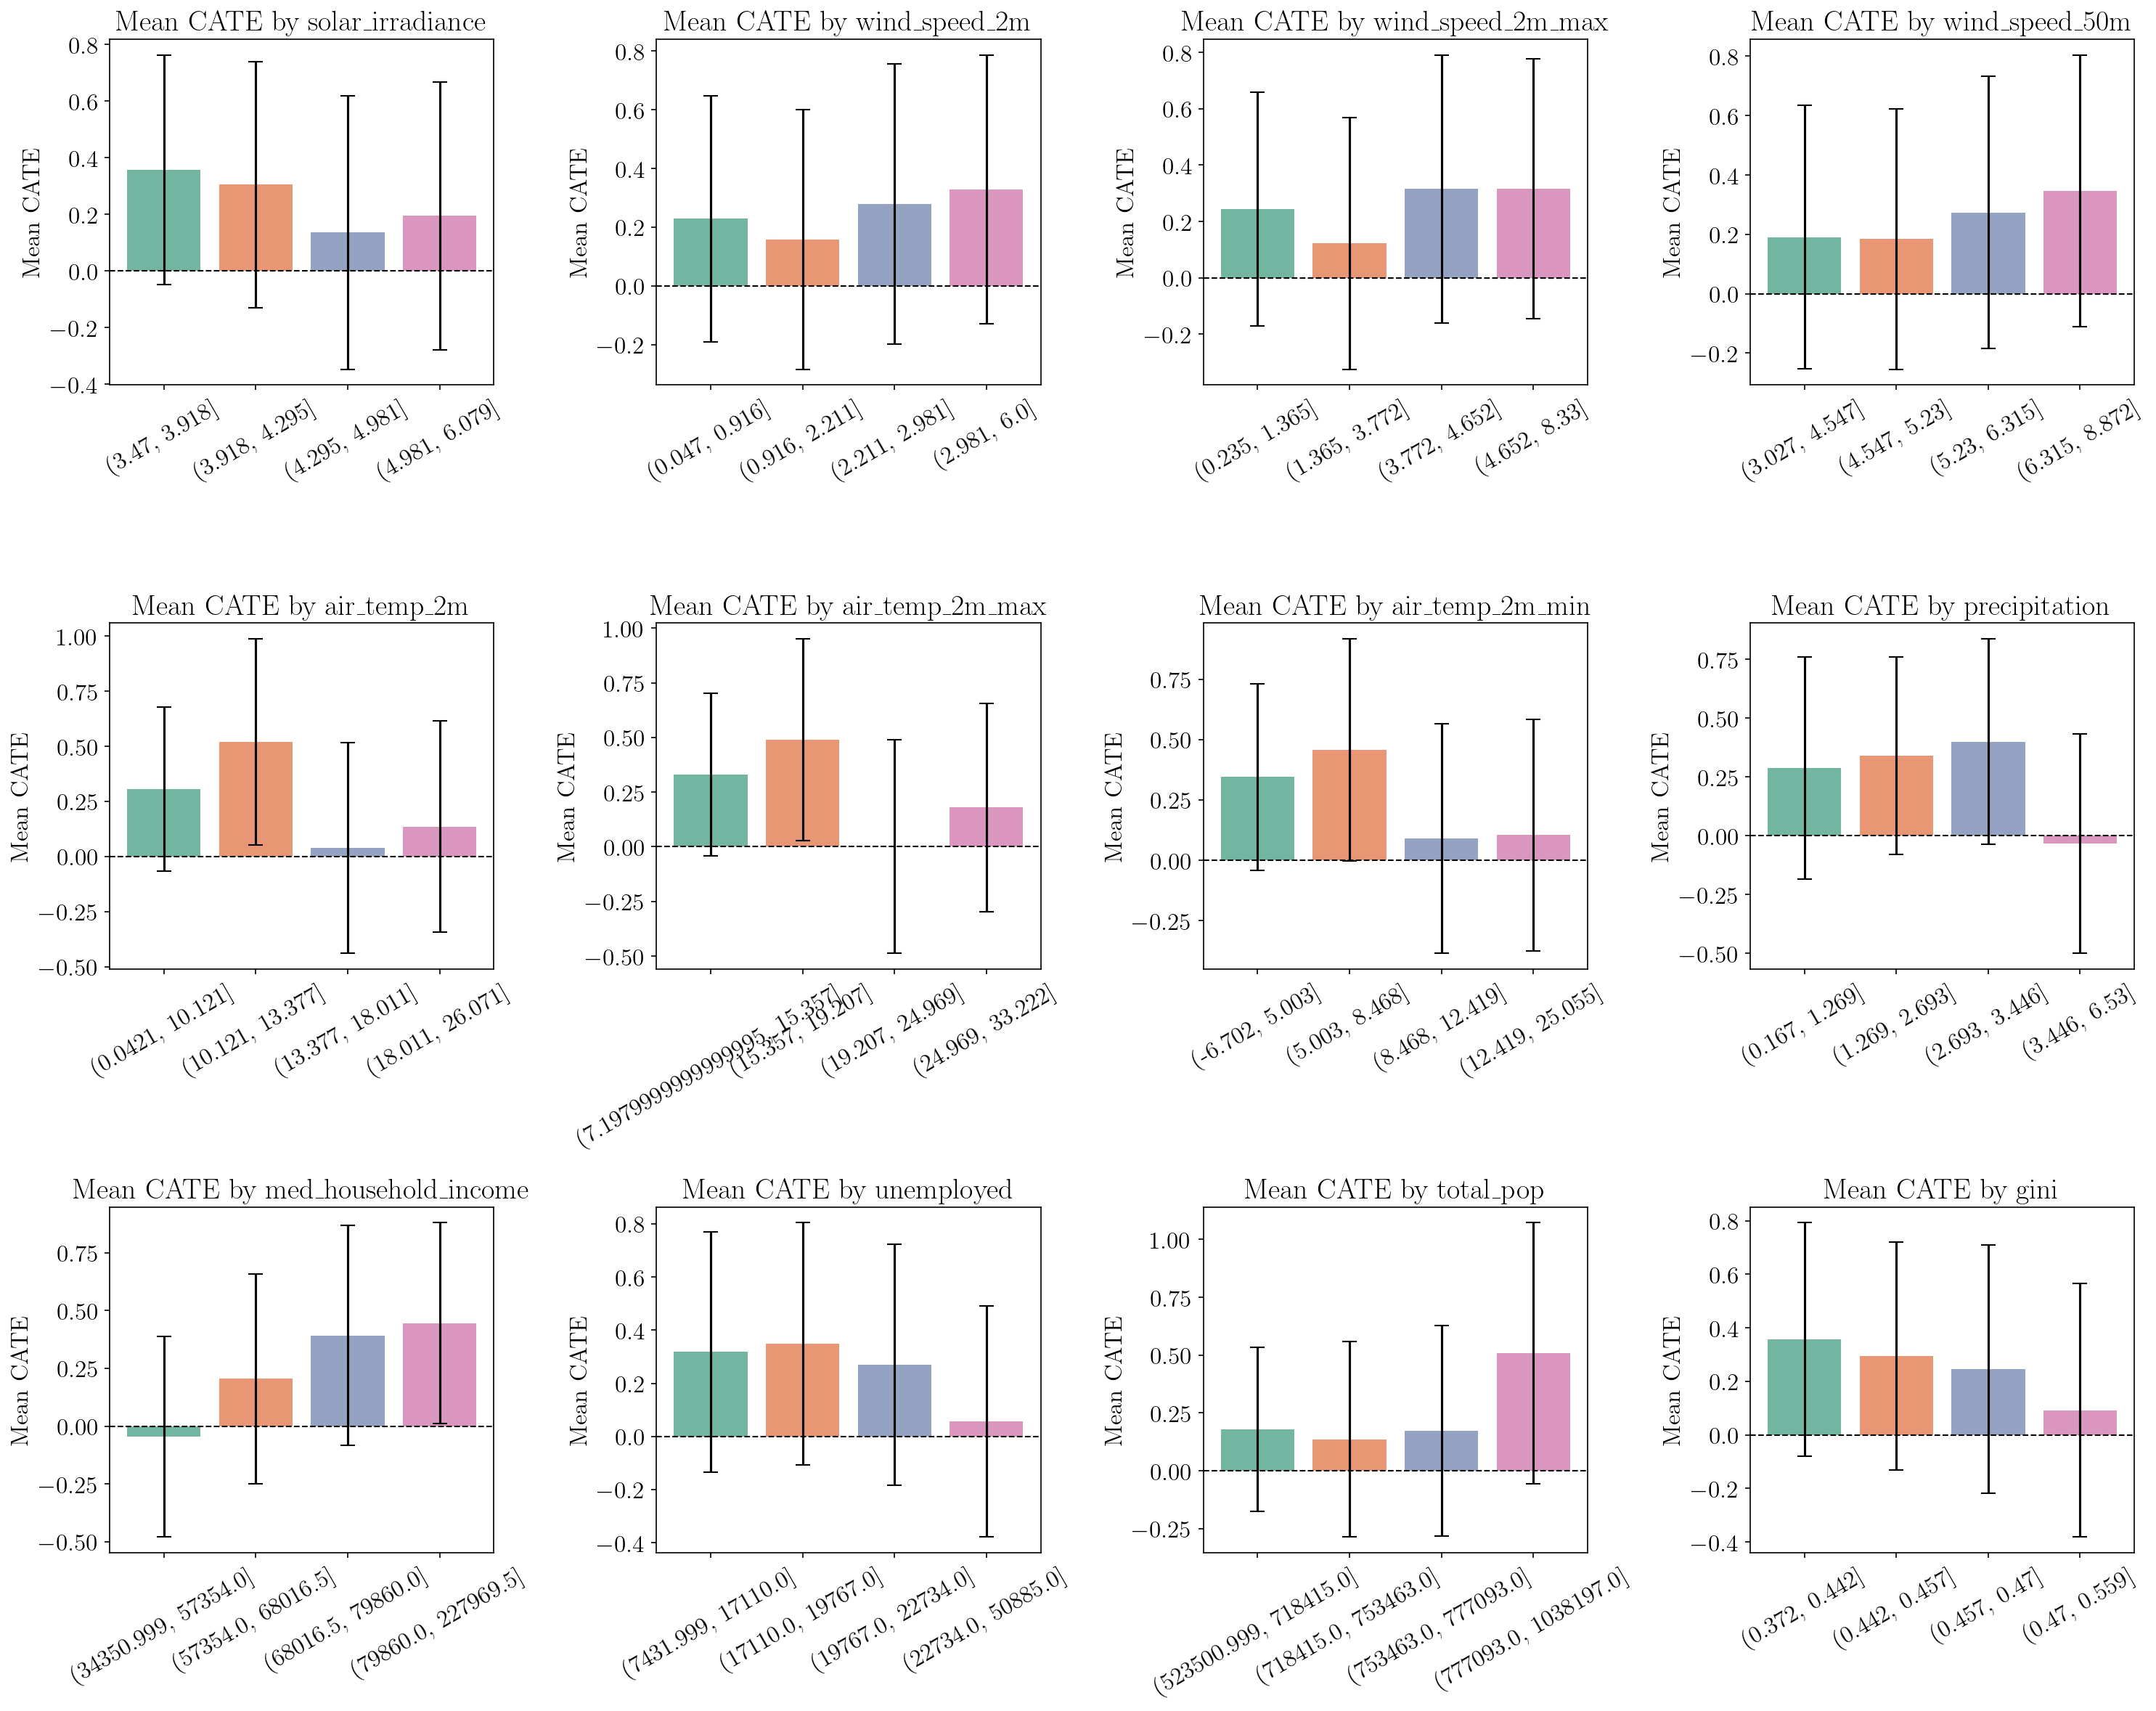

In [122]:
# Fig A.6: CATE by numeric covariate
fig, axes = plt.subplots(3, 4, figsize=(20, 16), dpi=150)
tech_cols = [col for col in X.columns if 'technology' in col.lower()]
for ax, cov in zip(axes.flatten(), X_num.columns):
    if cov not in df_res.columns:
        continue
    uniq = df_res[cov].unique()
    if len(uniq) > 4:
        bins = pd.qcut(df_res[cov], 4)
    else:
        bins = df_res[cov]
    sub = (df_res.assign(_bin=bins).groupby('_bin')[['cate','ci_low','ci_high']].mean().reset_index())
    sub['_bin_str'] = sub['_bin'].astype(str)
    sns.barplot(data=sub, x='_bin_str', y='cate', ax=ax, palette='Set2' , hue='_bin_str', legend=False)

    errs = [sub['cate'] - sub['ci_low'], sub['ci_high'] - sub['cate']]
    ax.errorbar(x=np.arange(len(sub)), y=sub['cate'], yerr=errs, fmt='none', ecolor='black', capsize=5)
    ax.set_title(f"Mean CATE by {cov}")
    ax.set_ylabel("Mean CATE")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.savefig('figures/Results/cate_by_numeric_covariate.png', dpi=200)
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



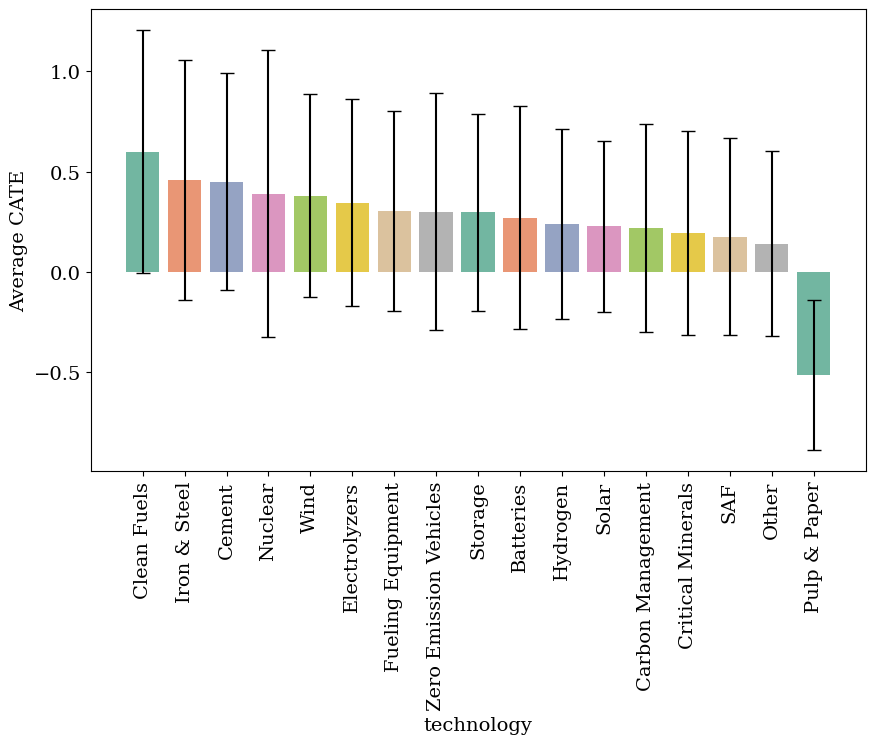

In [132]:
results = []
for i, row in df_res.iterrows():
    for col in tech_cols:
        if row[col] == 1:
            results.append({
                'cate': row['cate'],
                'ci_low': row['ci_low'],
                'ci_high': row['ci_high'],
                'technology': col,
            })
results_df = pd.DataFrame(results)
results_df['technology'] = results_df['technology'].str.split('_').str[1]

# CATE by technology
tech_cate = results_df.groupby('technology')[['cate', 'ci_low', 'ci_high']].mean()
tech_cate = tech_cate.reset_index()
tech_cate = tech_cate.rename(columns={'cate': 'avg_cate'})
tech_cate = tech_cate.sort_values(by='avg_cate', ascending=False)

plt.rcParams['text.usetex'] = False 
# set font size
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
sns.barplot(x='technology', y='avg_cate', data=tech_cate, palette='Set2')
plt.errorbar(x=tech_cate['technology'], y=tech_cate['avg_cate'], 
             yerr=[tech_cate['avg_cate'] - tech_cate['ci_low'], tech_cate['ci_high'] - tech_cate['avg_cate']], 
             fmt='none', capsize=5, color='black')
plt.xticks(rotation=90)
plt.ylabel('Average CATE')
# plt.title('Average CATE by Technology')
plt.savefig('figures/Results/cate_by_technology.png', dpi=200)
plt.show()

In [98]:
# Result summary and economic implications
capex_raw = subset.loc[X_trim.index, 'log_Estimated_Total_Facility_CAPEX'] 
capex_raw = np.exp(capex_raw) - 1 # transform back, now in million USD 2023
bench_capex = capex_raw.median() 
ate_log  = causal_forest.ate(X_trim.values)
ate_pct  = np.expm1(ate_log) * 100
ate_usd  = np.expm1(ate_log) * bench_capex
df_res['CATE_pct'] = np.expm1(df_res['cate']) * 100
df_res['CATE_usd'] = np.expm1(df_res['cate']) * bench_capex

print(f"ATE = {ate_log:.4f} log-pts -> {ate_pct:.1f}% "
      f"(~ ${ate_usd:.2f} million on a ${bench_capex:.2f} million bench project)")
print(df_res[['CATE_pct', 'CATE_usd']].describe(percentiles=[.1,.25,.5,.75,.9]))

ATE = 0.2915 log-pts -> 33.8% (~ $2.79 million on a $8.24 million bench project)
          CATE_pct     CATE_usd
count  7372.000000  7372.000000
mean     40.443930     3.331501
std      66.894284     5.510305
min     -69.908153    -5.758567
10%     -25.171629    -2.073471
25%       0.386189     0.031812
50%      28.834095     2.375160
75%      59.686595     4.916584
90%     114.739487     9.451474
max     555.268820    45.739342


#### Validation

Fold 1 — Test size: 1475  |  MSE: 0.020  |  R²: 0.919
Fold 2 — Test size: 1475  |  MSE: 0.017  |  R²: 0.930
Fold 3 — Test size: 1474  |  MSE: 0.019  |  R²: 0.922
Fold 4 — Test size: 1474  |  MSE: 0.021  |  R²: 0.914
Fold 5 — Test size: 1474  |  MSE: 0.022  |  R²: 0.910

Overall CV performance:
 → Mean MSE: 0.020  ± 0.002
 → Mean R² : 0.919  ± 0.007


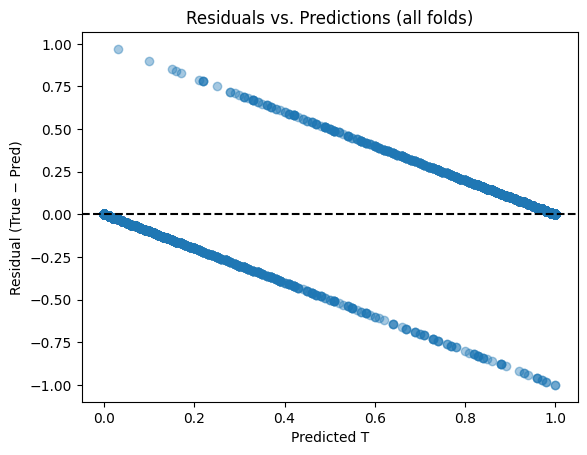

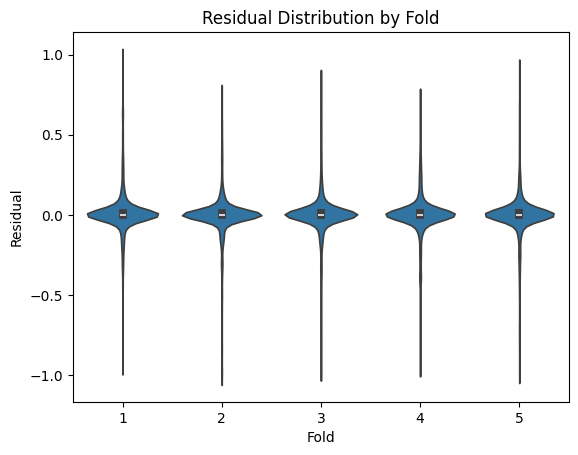

In [899]:
from sklearn.ensemble   import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics    import mean_squared_error, r2_score

# --- Prepare to collect results --- 
mse_scores = []
r2_scores  = []
all_folds  = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_trim, T_trim)):
    # split data
    X_train, X_test = X_trim.iloc[train_idx], X_trim.iloc[test_idx]
    T_train, T_test = T_trim.iloc[train_idx], T_trim.iloc[test_idx]
    
    # fit model
    model = RandomForestRegressor(random_state=18)
    model.fit(X_train, T_train)
    
    # predict
    preds = model.predict(X_test)
    
    # metrics
    mse = mean_squared_error(T_test, preds)
    r2  = r2_score(T_test, preds)
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Fold {fold_idx+1} — Test size: {len(test_idx)}  |  MSE: {mse:.3f}  |  R²: {r2:.3f}")
    
    # stash predictions for later
    df_fold = X_test.copy()
    df_fold['T_true']   = T_test.values
    df_fold['T_pred']   = preds
    df_fold['fold']     = fold_idx + 1
    all_folds.append(df_fold)

# --- aggregate results --- 
results_df = pd.concat(all_folds, ignore_index=True)

print("\nOverall CV performance:")
print(f" → Mean MSE: {np.mean(mse_scores):.3f}  ± {np.std(mse_scores):.3f}")
print(f" → Mean R² : {np.mean(r2_scores):.3f}  ± {np.std(r2_scores):.3f}")

# --- Optional: residual plot --- 
plt.scatter(results_df['T_pred'], 
            results_df['T_true'] - results_df['T_pred'], 
            alpha=0.4)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel("Predicted T")
plt.ylabel("Residual (True − Pred)")
plt.title("Residuals vs. Predictions (all folds)")
plt.show()

# --- Optional: fold-wise error distribution --- 
import seaborn as sns  # for nicer boxplots
sns.violinplot(x='fold', y=results_df['T_true'] - results_df['T_pred'], data=results_df)
plt.xlabel("Fold")
plt.ylabel("Residual")
plt.title("Residual Distribution by Fold")
plt.show()

#### Other results (not that helpful)

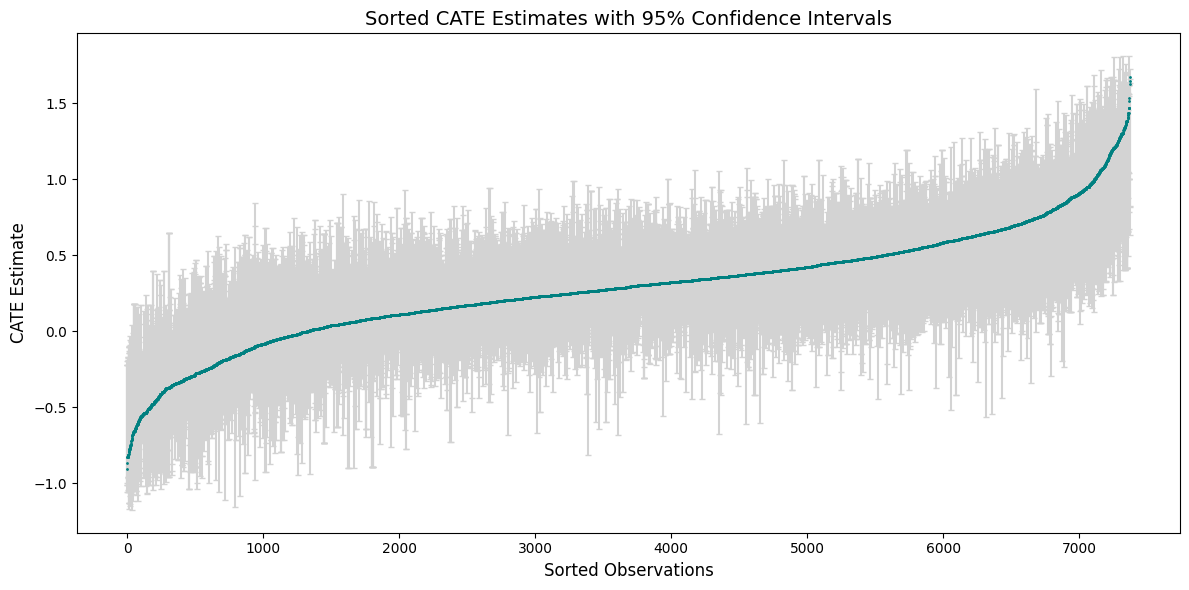

In [843]:
# 1. Sorted CATE Estimates with 95% Confidence Intervals
sorted_idx = np.argsort(cate_preds)
sorted_cate = cate_preds[sorted_idx]
sorted_lb = lb[sorted_idx]
sorted_ub = ub[sorted_idx]

plt.figure(figsize=(12, 6))
plt.errorbar(
    range(len(sorted_cate)),
    sorted_cate,
    yerr=[abs(sorted_cate - sorted_lb), abs(sorted_ub - sorted_cate)],
    fmt='o',
    markersize=1,
    color='teal',
    ecolor='lightgray',
    capsize=2,
)
plt.title('Sorted CATE Estimates with 95% Confidence Intervals', fontsize=14)
plt.xlabel('Sorted Observations', fontsize=12)
plt.ylabel('CATE Estimate', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import shap

# Select a random sample from X as background data for KernelExplainer
np.random.seed(123)
background = X.values[np.random.choice(X.shape[0], size=50, replace=False)]

# Define a prediction function that returns the CATE estimates for given covariate values
def cate_predict(x):
    return causal_forest.effect(x)

# Create a KernelExplainer for the causal forest's effect function
explainer = shap.KernelExplainer(cate_predict, background)

# Compute SHAP values on a subset (e.g., first 100 observations)
X_subset = X.values[:100]
shap_values = explainer.shap_values(X_subset)

# Plot a summary of the SHAP values
shap.summary_plot(shap_values, X_subset, feature_names=X.columns)

Provided model function fails when applied to the provided data set.


AssertionError: Dimension mis-match of X with fitted X